# Setup

## Imports

In [1]:
# Import Libraries
library(plyr)
library(tidyverse)
library(lme4)
library(car)
library(ggplot2)
library(lmerTest)
library(broom)
library(data.table)
library(pander)
library(emmeans)
library(ggsignif)

# Load helper functions
source("r_scripts/helper_functions.R")

## set universal plot size:
options(repr.plot.width=7, repr.plot.height=3.5)

# avoids scientific notation
options(scipen=999) 

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1       ✔ purrr   0.3.2  
✔ tibble  2.1.1       ✔ dplyr   0.8.0.1
✔ tidyr   0.8.3       ✔ stringr 1.4.0  
✔ readr   1.3.1       ✔ forcats 0.4.0  
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::arrange()   masks plyr::arrange()
✖ purrr::compact()   masks plyr::compact()
✖ dplyr::count()     masks plyr::count()
✖ dplyr::failwith()  masks plyr::failwith()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::id()        masks plyr::id()
✖ dplyr::lag()       masks stats::lag()
✖ dplyr::mutate()    masks plyr::mutate()
✖ dplyr::rename()    masks plyr::rename()
✖ dplyr::summarise() masks plyr::summarise()
✖ dplyr::summarize() masks plyr::summarize()
Loading required package: Matrix

Attaching package: ‘Matrix’

The following object is masked from ‘package:tidyr’:

    expand

Loading required package: carData

Attaching package: ‘car’

The following object i

### Load and manipulate data

In [2]:
# Load Data
load("data/FoodRegfMRI_dt.RData")
dt = full_dt

In [3]:
head(dt)

food,subject,block,cond,resp,rt,pre_liking,post_liking,taste,health
KashiBars_4_3bars.jpg,101,1,Respond Naturally,4,1.802056,4,3,4,4
BBQCrisps_6_1cup.jpg,101,1,Respond Naturally,3,1.093640,4,3,4,4
Peanuts_4_0.25c.jpg,101,1,Respond Naturally,2,1.722257,4,4,5,6
Tostitos_5_25chips.jpg,101,1,Respond Naturally,3,1.041150,4,4,4,3
RiceChex_4_0.25Cups.jpg,101,1,Respond Naturally,3,1.051524,4,3,3,3
Cheerios_5_2c.jpg,101,1,Respond Naturally,2,1.008364,3,3,4,4


In [3]:
# add some columns and center predictors, remove NA rows
dt = process_data_table(dt)

# Make condition dts
dt_nat = dt[dt$cond == "Respond Naturally",]
dt_health = dt[dt$cond == "Focus on Healthiness",]
dt_dd = dt[dt$cond == "Decrease Desire",]

# means by subject and by condition
  # and calculate health/taste change w/baseline
dt_subj = by_subject(dt)

# Load Hause helper functions (for some reason it breaks the by_subject() function if run first)
source("https://raw.githubusercontent.com/hauselin/Rcode/master/summaryh.R")
source("https://raw.githubusercontent.com/hauselin/Rcode/master/se.R")

ERROR: Error in map_lgl(.x, .p, ...): object 'cond' not found


In [6]:
# Use resp instead of choice to calculate slopes
# Natural
model_nc <- glmer(choice ~ taste_c + health_c + (1 + taste_c + health_c|subject),
               data = dt_nat, family = binomial,
               control = glmerControl(optimizer= 'bobyqa'))

model_np <- lmer(resp ~ taste_c + health_c + (1 + taste_c + health_c|subject), 
              data = dt_nat)

model = model_np

dt_subj$intercept[dt_subj$cond=="Respond Naturally"] = coef(model)$subject[,1]
dt_subj$taste_slope[dt_subj$cond=="Respond Naturally"] = coef(model)$subject[,2]
dt_subj$health_slope[dt_subj$cond=="Respond Naturally"] = coef(model)$subject[,3]
  
# Decrease
model_dc <- glmer(choice ~ taste_c + health_c + (1 + taste_c + health_c|subject),
               data = dt_dd, family = binomial,
               control = glmerControl(optimizer= 'bobyqa'))

model_dp <- lmer(resp ~ taste_c + health_c + (1 + taste_c + health_c|subject), 
              data = dt_dd)

model = model_dp

dt_subj$intercept[dt_subj$cond=="Decrease Desire"] = coef(model)$subject[,1]
dt_subj$taste_slope[dt_subj$cond=="Decrease Desire"] = coef(model)$subject[,2]
dt_subj$health_slope[dt_subj$cond=="Decrease Desire"] = coef(model)$subject[,3]


# Health
model_hc <- glmer(choice ~ taste_c + health_c + (1 + taste_c + health_c|subject),
               data = dt_health, family = binomial,
               control = glmerControl(optimizer= 'bobyqa'))

model_hp <- lmer(resp ~ taste_c + health_c + (1 + taste_c + health_c|subject), 
              data = dt_health)

model = model_hp

dt_subj$intercept[dt_subj$cond=="Focus on Healthiness"] = coef(model)$subject[,1]
dt_subj$taste_slope[dt_subj$cond=="Focus on Healthiness"] = coef(model)$subject[,2]
dt_subj$health_slope[dt_subj$cond=="Focus on Healthiness"] = coef(model)$subject[,3]

# model with everything
# model_all <- lmer(resp ~ taste_c + health_c + cond + (1 + taste_c + health_c + cond|subject), data = dt)

# summary(model_all)

# Calculate difference of slopes with baseline (natural)
dt_subj = dt_subj %>%
  group_by(subject) %>%
  mutate( health_slope_change = health_slope - health_slope[cond=="Respond Naturally"],
          taste_slope_change = taste_slope - taste_slope[cond=="Respond Naturally"]
  )

# Label based on regulatory success (3 categories)
dt_subj = dt_subj %>%
  group_by(cond) %>%
  mutate( health_slope_change_cat = ntile(health_slope_change, 3),
          taste_slope_change_cat = ntile(taste_slope_change, 3)
  )

# Apply labels to original long dataframe
dt_merged = merge(dt, dt_subj, by=c("subject", "cond"))

Warning message:
“Unknown or uninitialised column: 'intercept'.”Warning message:
“Unknown or uninitialised column: 'taste_slope'.”Warning message:
“Unknown or uninitialised column: 'health_slope'.”

In [7]:
head(dt_merged, 5)

subject,cond,food,block,resp.x,rt.x,pre_liking.x,post_liking.x,taste.x,health.x,⋯,choice.y,post_pre.y,post_pre_c.y,intercept,taste_slope,health_slope,health_slope_change,taste_slope_change,health_slope_change_cat,taste_slope_change_cat
101,Decrease Desire,ProMax_4_1bar.jpg,3,2,0.8472029,4,3,3,3,⋯,0.2666667,-0.2,0.01022349,1.963392,0.3174135,0.07434354,-0.02989023,-0.09816493,1,2
101,Decrease Desire,TeriyakiJerky_2_1pc.jpg,7,1,1.1951755,3,2,2,4,⋯,0.2666667,-0.2,0.01022349,1.963392,0.3174135,0.07434354,-0.02989023,-0.09816493,1,2
101,Decrease Desire,SkittlesSour_6_0.5pack.jpg,3,1,0.8027384,3,3,3,1,⋯,0.2666667,-0.2,0.01022349,1.963392,0.3174135,0.07434354,-0.02989023,-0.09816493,1,2
101,Decrease Desire,RufflesSourCreamOnion_3_5chips.jpg,6,2,0.9040389,5,5,4,3,⋯,0.2666667,-0.2,0.01022349,1.963392,0.3174135,0.07434354,-0.02989023,-0.09816493,1,2
101,Decrease Desire,AllBranCereal_2_1tbsp.jpg,5,2,1.0302339,4,4,4,5,⋯,0.2666667,-0.2,0.01022349,1.963392,0.3174135,0.07434354,-0.02989023,-0.09816493,1,2


In [106]:
# want to look only at the subjects that were kept
good_subjects = c(101:104, 106:112, 114, 116, 118:121, 123:126, 129:137, 139:140, 142:148, 150, 152:158, 162:164)
# remove "bad" subjects
dt = dt %>%
    filter(subject %in% good_subjects)

In [140]:
# make subjects as factors
dt$subject = as.factor(dt$subject)

---
This, below, is all done for plotting order purposes

In [146]:
dt2 = dt

In [147]:
dt2$cond = ordered(dt$cond, levels = c("Respond Naturally",
                                       "Focus on Healthiness",
                                      "Decrease Desire"))

In [148]:
dt2$cond = plyr::mapvalues(dt2$cond, 
          from = c("Respond Naturally", "Focus on Healthiness", "Decrease Desire"),
          to = c("aNaturally", "bHealthiness", "cDesire"))

# RT

## Basics

#### Accept/Reject

In [ ]:
dt2$choice

resp,mean_rt
1,1.241348
2,1.414950
3,1.499893
4,1.318283


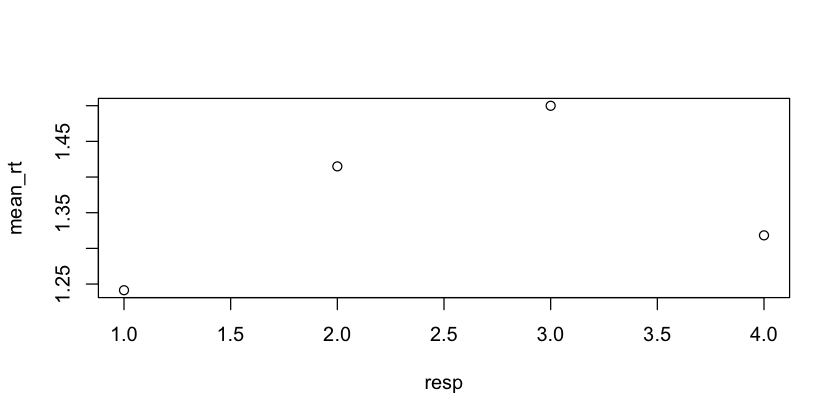

In [45]:
x = dt2 %>%
    group_by(resp) %>%
    summarise(mean_rt = mean(rt))
x
plot(x)

In [47]:
dt2 %>%
    group_by(choice) %>%
    summarise(mean_rt = mean(rt))

choice,mean_rt
0,1.347747
1,1.454076


### By Condition

#### Means + Plot

##### Violin

QUESTION: Should this be subject means? Or all data?

cond,N,rt,sd,se,ci
aNaturally,50,1.321540,0.2977508,0.04210832,0.08461983
bHealthiness,50,1.404437,0.3402706,0.04812153,0.09670384
cDesire,50,1.439675,0.3843908,0.05436106,0.10924265


Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.


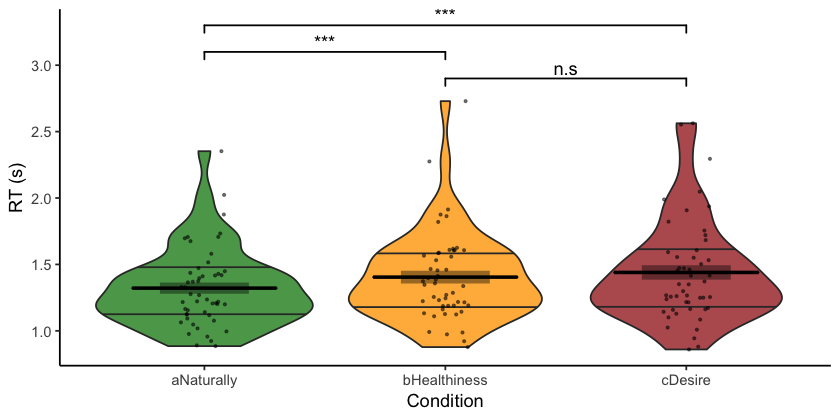

In [256]:
# Reaction time by conditions
rts_sub = dt2 %>%
    se(measurevar = "rt", groupvars = c("cond", "subject"))
rts_group = rts_sub %>%
    se(measurevar = "rt", groupvars = c("cond"))
rts_group


# Plot 
plot = ggplot(rts_sub, aes(cond, rt, fill = cond)) +
    geom_violin(draw_quantiles = c(0.25, 0.75), size=0.5, alpha=0.8, show.legend = F) +
    geom_linerange(aes(ymin = rt-se, ymax = rt+se), size=25, alpha=0.4, data=rts_group) +
    geom_crossbar(stat="summary", fun.y=mean, fun.ymax=mean, fun.ymin=mean, fatten=2, width=0.6, show.legend = F) +
    geom_jitter(height = 0, width = 0.1, size = 0.5, alpha=0.5, show.legend = F) +
    xlab("Condition") +
    ylab("RT (s)") +
    scale_fill_discrete(guide=FALSE) +
    scale_fill_manual(values = c("forestgreen", "orange", "brown")) +
    theme_classic()

plot + 
    geom_signif(annotations = c("n.s", "***", "***"),
              y_position = c(2.9, 3.1, 3.3), xmin=c(2,1,1), xmax=c(3,2,3))

ggsave("../../3_4_outputs/plots/rt.pdf", width = 20, height = 15, units = "cm")


##### Density

In [12]:
# spread data for significance bars
rts = rts_group %>% 
    select('cond', 'rt') %>% 
    spread('cond', 'rt')
rts

aNaturally,bHealthiness,cDesire
1.327698,1.394506,1.426847


In [13]:
plot = ggplot(rts_sub, aes(x=rt, fill=cond, color=cond)) +
    geom_density(alpha = 0.3, show.legend = F)+
    # vertical mean lines
    geom_segment(data=rts_group, aes(x = rt, y = 0, xend = rt, yend=1.7)) +
    # bottom black line
    geom_segment(data=accept_rate_group, aes(x = 0.5, y = 0, xend = 2.5, yend=0), color='black', size=0.3) +
    labs(x="RT (s)", y="Density", colour = "Condition") +
    xlim(0.5, 2.5) +
   theme_classic()

plot + 
    geom_segment(aes(x = rts$`Respond Naturally`, y = 1.85, 
                        xend = rts$`Focus on Healthiness`, yend = 1.85), size =0.2, color = 'black') +
        annotate("text", x = 1.36, y = 1.88, label = "***", size = 4) +
    geom_segment(aes(x = rts$`Respond Naturally`, y = 1.75, 
                        xend = rts$`Decrease Desire`, yend = 1.75), size =0.2, color = 'black') +
        annotate("text", x = 1.38, y = 1.78, label = "***", size = 4) 
    

ERROR: Error in fortify(data): object 'accept_rate_group' not found


#### Statistical Significance

In [18]:
rt.lmer <- lmer (rt ~ cond + (1 + cond|subject), data = dt)
summaryh(rt.lmer)

term,results
(Intercept),"b = 1.33, SE = 0.04, t(61) = 37.51, p < .001, r = 0.98"
condFocus on Healthiness,"b = 0.07, SE = 0.02, t(61) = 3.81, p < .001, r = 0.44"
condDecrease Desire,"b = 0.10, SE = 0.02, t(61) = 4.49, p < .001, r = 0.50"


In [22]:
anova(lmer(rt ~ cond + (1 + cond |subject), data=dt))

,Sum Sq,Mean Sq,NumDF,DenDF,F value,Pr(>F)
cond,4.970999,2.485499,2,61.10917,10.95846,0.00008569054


In [23]:
rt.emm = emmeans(rt.lmer, list(pairwise ~ cond), adjust = "tukey")
summary(rt.emm$`pairwise differences of cond`)

Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, set emm_options(pbkrtest.limit = 16511) or larger,
but be warned that this may result in large computation time and memory use.
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, set emm_options(lmerTest.limit = 16511) or larger,
but be warned that this may result in large computation time and memory use.


contrast,estimate,SE,df,z.ratio,p.value
Respond Naturally - Focus on Healthiness,-0.06818612,0.01789572,Inf,-3.810192,0.00040806958
Respond Naturally - Decrease Desire,-0.10096268,0.02246242,Inf,-4.494738,0.00002075102
Focus on Healthiness - Decrease Desire,-0.03277656,0.01809001,Inf,-1.811860,0.16564814488


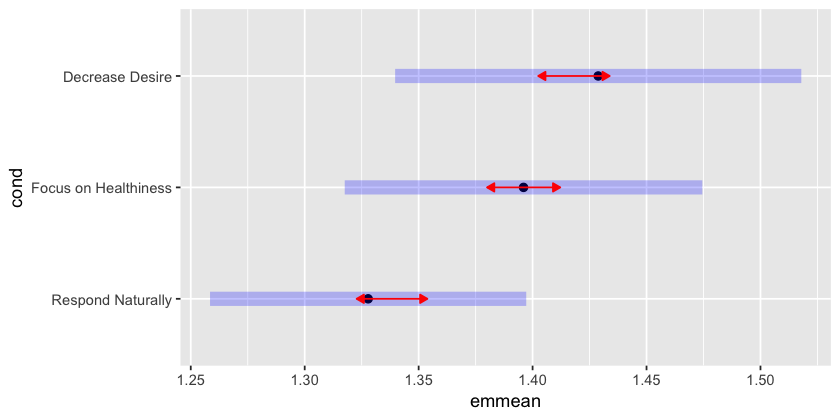

In [9]:
plot(rt.emm, comparisons = TRUE)

### By Condition and Choice

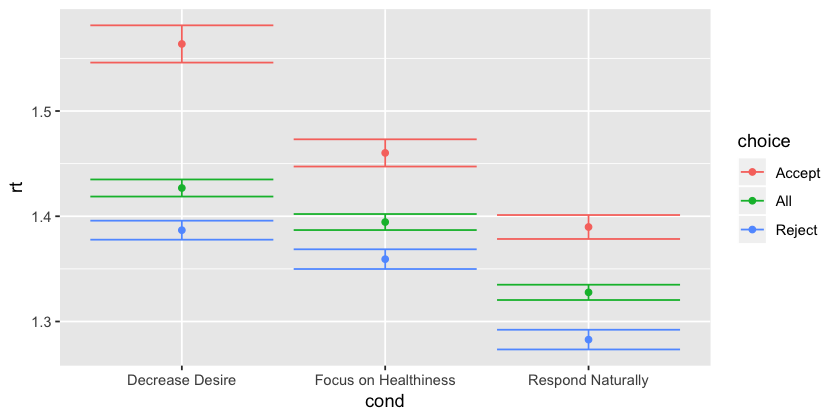

In [51]:
# RT by condition
rts = dt %>%
    se(measurevar = "rt", groupvars = c("cond", "choice"))
rts$choice = plyr::mapvalues(rts$choice, c(0,1), c('Reject', 'Accept'))

rts_all = dt %>%
    se(measurevar = "rt", groupvars = c("cond")) %>%
    mutate("choice" = "All")

rts = rbind(rts, rts_all)

# Plot 
ggplot(rts, aes(cond, rt, color = choice)) +
  geom_point() +
  geom_errorbar(aes(ymin = rt-se, ymax = rt+se))

# Acceptance Rate

### By Condition

#### Means + Plot

##### Violin

In [ ]:
rts_group = rts_sub %>%
    se(measurevar = "rt", groupvars = c("cond"))
rts_group

cond,N,choice,sd,se,ci
aNaturally,50,0.4303472,0.1802300,0.02548837,0.05122080
bHealthiness,50,0.3570476,0.1354439,0.01915466,0.03849273
cDesire,50,0.2280827,0.1351033,0.01910649,0.03839593


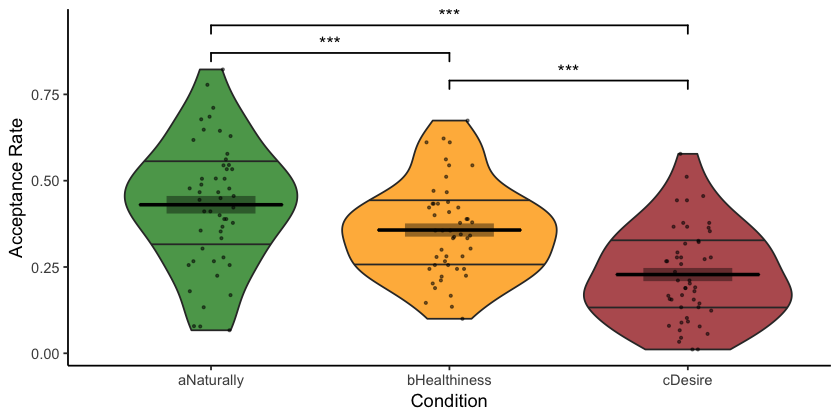

In [255]:
# Acceptance by condition
accept_rate_sub = dt2 %>%
    se(measurevar = "choice", groupvars = c("cond", "subject"))

accept_rate_group = accept_rate_sub %>%
    se(measurevar = "choice", groupvars = c("cond"))

#pander(accept_rate_group)
accept_rate_group

# Plot 
plot = ggplot(accept_rate_sub, aes(cond, choice, fill = cond)) +
    geom_violin(draw_quantiles = c(0.25, 0.75), size=0.5, alpha=0.8, show.legend = F) +
    geom_linerange(aes(ymin = choice-se, ymax = choice+se), size=25, alpha=0.4, data=accept_rate_group) +
    geom_crossbar(stat="summary", fun.y=mean, fun.ymax=mean, fun.ymin=mean, fatten=2, width=0.6, show.legend = F) +
    geom_jitter(height = 0, width = 0.1, size = 0.5, alpha=0.5, show.legend = F) +
    xlab("Condition") +
    ylab("Acceptance Rate") +
    scale_fill_manual(values = c("forestgreen", "orange", "brown")) +
    theme_classic()

plot + 
    geom_signif(annotations = c("***", "***", "***"),
              y_position = c(0.79, 0.87, 0.95), xmin=c(2,1,1), xmax=c(3,2,3))

ggsave("../../3_4_outputs/plots/accept.pdf", width = 20, height = 15, units = "cm")


##### Density

In [117]:
rates = accept_rate_group %>% 
    select('cond', 'choice') %>% 
    spread('cond', 'choice')
rates

Decrease Desire,Focus on Healthiness,Respond Naturally
0.2264631,0.3493101,0.4195601


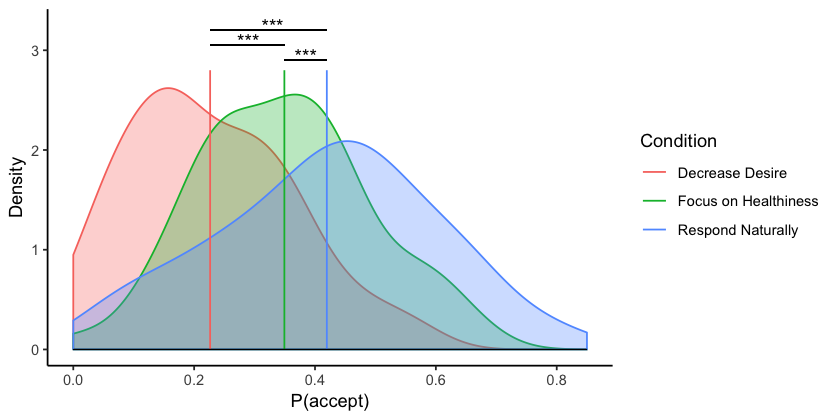

In [173]:
plot = ggplot(accept_rate_sub, aes(x=choice, fill=cond, color=cond)) +
    geom_density(alpha = 0.3, show.legend = F)+
    # vertical mean lines
    geom_segment(data=accept_rate_group, aes(x = choice, y = 0, xend = choice, yend=2.8)) +
    # bottom black line
    geom_segment(data=accept_rate_group, aes(x = 0, y = 0, xend = 0.85, yend=0), color='black', size=0.3) +
    labs(x="P(accept)", y="Density", colour = "Condition") +
   theme_classic()

plot + 
    geom_segment(aes(x = rates$`Focus on Healthiness`, y = 2.9, 
                        xend = rates$`Respond Naturally`, yend = 2.9), size =0.2, color = 'black') +
        annotate("text", x = 0.385, y = 2.95, label = "***", size = 4) +
    geom_segment(aes(x = rates$`Decrease Desire`, y = 3.2, 
                        xend = rates$`Respond Naturally`, yend = 3.2), size =0.2, color = 'black') +
        annotate("text", x = 0.33, y = 3.25, label = "***", size = 4) +
    geom_segment(aes(x = rates$`Decrease Desire`, y = 3.05, 
                        xend = rates$`Focus on Healthiness`, yend = 3.05), size =0.2, color = 'black') +
        annotate("text", x = 0.29, y = 3.1, label = "***", size = 4) 

#### Statistical Significance

In [149]:
accept.lmer <- lmer (choice ~ cond + (1 + cond|subject), data = dt)
summaryh(accept.lmer)

term,results
(Intercept),"b = 0.43, SE = 0.03, t(49) = 16.88, p < .001, r = 0.92"
condFocus on Healthiness,"b = −0.07, SE = 0.01, t(49) = −4.99, p < .001, r = 0.58"
condDecrease Desire,"b = −0.20, SE = 0.03, t(49) = −8.06, p < .001, r = 0.75"


In [150]:
anova(lmer (choice ~ cond + (1 + cond|subject), data = dt))

,Sum Sq,Mean Sq,NumDF,DenDF,F value,Pr(>F)
cond,12.75037,6.375186,2,49.06955,32.45055,1.048913e-09


In [151]:
accept.emm = emmeans(accept.lmer, list(pairwise ~ cond), adjust = "tukey")
summary(accept.emm$`pairwise differences of cond`)

Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, set emm_options(pbkrtest.limit = 13386) or larger,
but be warned that this may result in large computation time and memory use.
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, set emm_options(lmerTest.limit = 13386) or larger,
but be warned that this may result in large computation time and memory use.


contrast,estimate,SE,df,z.ratio,p.value
Respond Naturally - Focus on Healthiness,0.07334252,0.01471054,Inf,4.985713,1.846545e-06
Respond Naturally - Decrease Desire,0.20237456,0.02512198,Inf,8.055677,4.118927e-14
Focus on Healthiness - Decrease Desire,0.12903204,0.01959637,Inf,6.584486,1.369487e-10


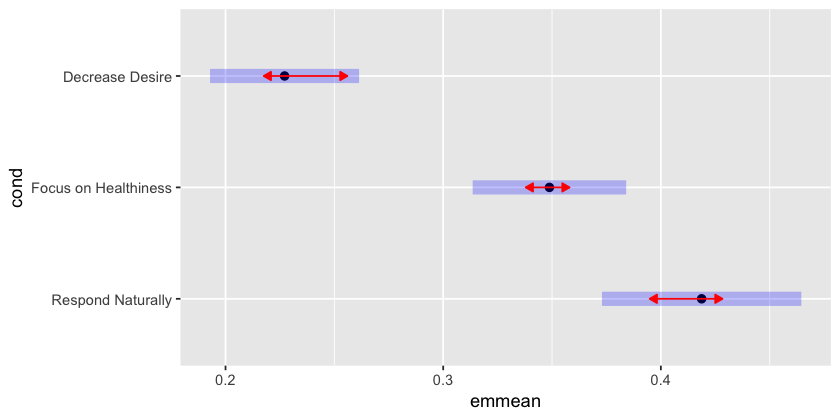

In [14]:
plot(accept.emm, comparisons = TRUE)

### Healthy & Untasty

#### Means + Plot

##### Violin

cond,N,choice,sd,se,ci
aNaturally,50,0.1865781,0.2395416,0.03387629,0.06807696
bHealthiness,50,0.3112992,0.2599596,0.03676384,0.07387971
cDesire,50,0.1283592,0.2102238,0.02973014,0.05974495


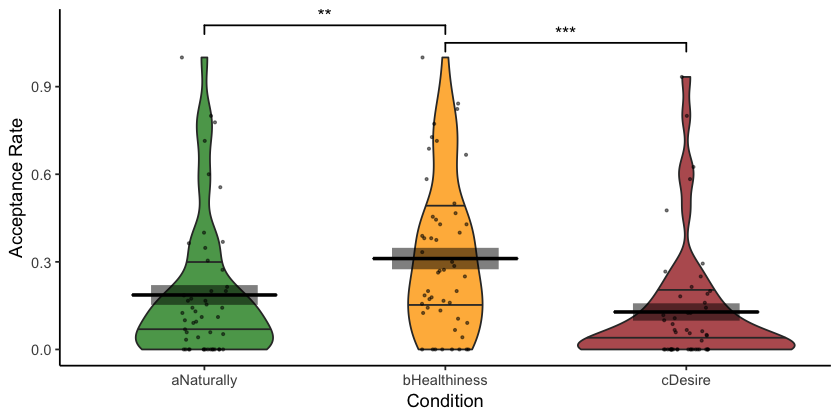

In [243]:
# Acceptance by condition
accept_hu_sub = dt2 %>%
    filter(taste<4, health>3) %>%
    se(measurevar = "choice", groupvars = c("cond", "subject"))

accept_hu_group = accept_hu_sub %>%
    se(measurevar = "choice", groupvars = c("cond"))

#pander(accept_hu_group)
accept_hu_group


# Plot 
plot = ggplot(accept_hu_sub, aes(cond, choice, fill = cond)) +
    geom_violin(draw_quantiles = c(0.25, 0.75), size=0.5, alpha=0.8, show.legend = F) +
    geom_linerange(aes(ymin = choice-se, ymax = choice+se), size=25, alpha=0.4, data=accept_hu_group) +
    geom_crossbar(stat="summary", fun.y=mean, fun.ymax=mean, fun.ymin=mean, fatten=2, width=0.6, show.legend = F) +
    geom_jitter(height = 0, width = 0.1, size = 0.5, alpha=0.5, show.legend = F) +
    xlab("Condition") +
    ylab("Acceptance Rate") +
    scale_fill_manual(values = c("forestgreen", "orange", "brown")) +
    theme_classic()

plot + 
    geom_signif(annotations = c("***", "**"),
              y_position = c(1.05, 1.11), xmin=c(2,1), xmax=c(3,2))

ggsave("../../3_4_outputs/plots/accept_hu.pdf", width = 20, height = 15, units = "cm")

##### Density

In [205]:
rates = accept_hu_group %>% 
    select('cond', 'choice') %>% 
    spread('cond', 'choice')
rates


Decrease Desire,Focus on Healthiness,Respond Naturally
0.1177686,0.3002008,0.1478439


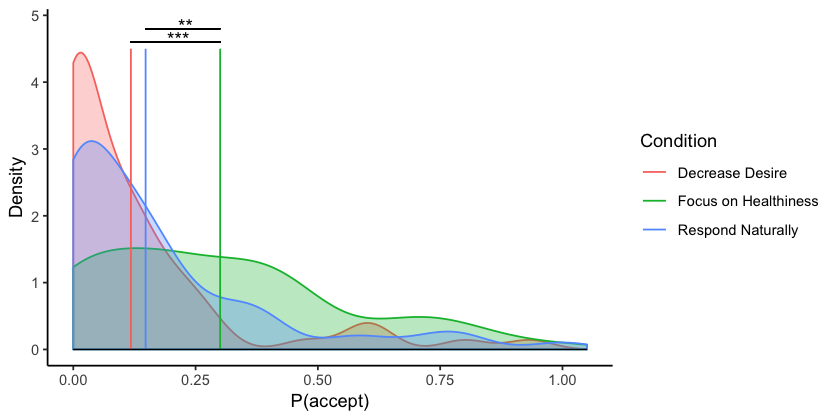

In [213]:
plot = ggplot(accept_hu_sub, aes(x=choice, fill=cond, color=cond)) +
    geom_density(alpha = 0.3, show.legend = F)+
    # vertical mean lines
    geom_segment(data=accept_hu_group, aes(x = choice, y = 0, xend = choice, yend=4.5)) +
    # bottom black line
    geom_segment(data=accept_hu_group, aes(x = 0, y = 0, xend = 1.05, yend=0), color='black', size=0.3) +
    labs(x="P(accept)", y="Density", colour = "Condition") +
   theme_classic()

plot + 
    geom_segment(aes(x = rates$`Respond Naturally`, y = 4.8, 
                        xend = rates$`Focus on Healthiness`, yend = 4.8), size =0.2, color = 'black') +
        annotate("text", x = 0.23, y = 4.85, label = "**", size = 4) +
    geom_segment(aes(x = rates$`Decrease Desire`, y = 4.6, 
                        xend = rates$`Focus on Healthiness`, yend = 4.6), size =0.2, color = 'black') +
        annotate("text", x = 0.215, y = 4.65, label = "***", size = 4) 


#### Statistical Significance

In [152]:
hu_dt = dt %>%
    filter(taste<4, health>3)

In [153]:
accept.lmer <- lmer (choice ~ cond + (1 + cond|subject), data = hu_dt)
summaryh(accept.lmer)

term,results
(Intercept),"b = 0.18, SE = 0.03, t(40) = 5.96, p < .001, r = 0.68"
condFocus on Healthiness,"b = 0.14, SE = 0.04, t(44) = 3.25, p = .002, r = 0.44"
condDecrease Desire,"b = −0.05, SE = 0.04, t(46) = −1.31, p = .195, r = 0.19"


In [154]:
anova(lmer (choice ~ cond + (1 + cond|subject), data = hu_dt))

,Sum Sq,Mean Sq,NumDF,DenDF,F value,Pr(>F)
cond,3.774459,1.887229,2,46.80643,16.5627,3.637127e-06


In [155]:
accept.emm = emmeans(accept.lmer, list(pairwise ~ cond), adjust = "tukey")
summary(accept.emm$`pairwise differences of cond`)

contrast,estimate,SE,df,t.ratio,p.value
Respond Naturally - Focus on Healthiness,-0.13777036,0.04245568,48.30661,-3.245039,5.944628e-03
Respond Naturally - Decrease Desire,0.05061606,0.03856692,48.24714,1.312422,3.952790e-01
Focus on Healthiness - Decrease Desire,0.18838642,0.03291145,47.40014,5.724039,2.031712e-06


### p(Accept) Healthy

#### Means + Plot

##### Violin

cond,N,choice,sd,se,ci
aNaturally,50,0.4830137,0.1959865,0.02771668,0.05569875
bHealthiness,50,0.5751899,0.2029954,0.02870789,0.05769066
cDesire,50,0.2878694,0.1812516,0.02563285,0.05151113


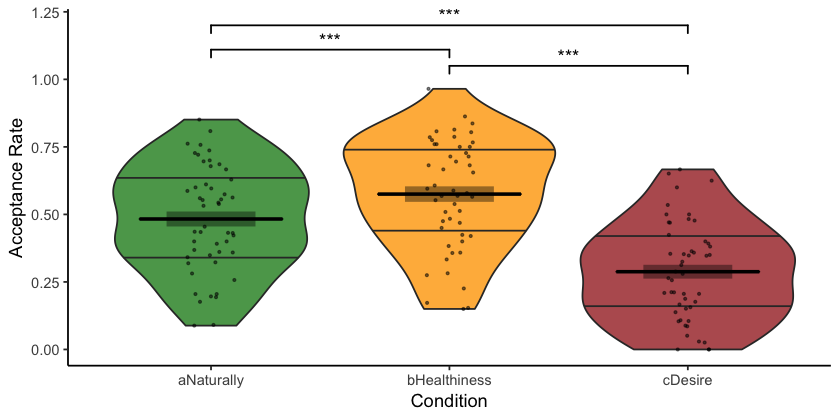

In [257]:
# Acceptance by condition
accept_h_sub = dt2 %>%
    filter(health>3) %>%
    se(measurevar = "choice", groupvars = c("cond", "subject"))

accept_h_group = accept_h_sub %>%
    se(measurevar = "choice", groupvars = c("cond"))

#pander(accept_hu_group)
accept_h_group


# Plot 
plot = ggplot(accept_h_sub, aes(cond, choice, fill = cond)) +
    geom_violin(draw_quantiles = c(0.25, 0.75), size=0.5, alpha=0.8, show.legend = F) +
    geom_linerange(aes(ymin = choice-se, ymax = choice+se), size=25, alpha=0.4, data=accept_h_group) +
    geom_crossbar(stat="summary", fun.y=mean, fun.ymax=mean, fun.ymin=mean, fatten=2, width=0.6, show.legend = F) +
    geom_jitter(height = 0, width = 0.1, size = 0.5, alpha=0.5, show.legend = F) +
    xlab("Condition") +
    ylab("Acceptance Rate") +
    scale_fill_manual(values = c("forestgreen", "orange", "brown")) +
    theme_classic()

plot + 
    geom_signif(annotations = c("***", "***", "***"),
              y_position = c(1.05, 1.11, 1.2), xmin=c(2,1,1), xmax=c(3,2,3))

ggsave("../../3_4_outputs/plots/accept_success.pdf", width = 20, height = 15, units = "cm")


##### Density

In [226]:
rates = accept_h_group %>% 
    select('cond', 'choice') %>% 
    spread('cond', 'choice')
rates

Decrease Desire,Focus on Healthiness,Respond Naturally
0.2906463,0.5526518,0.4707478


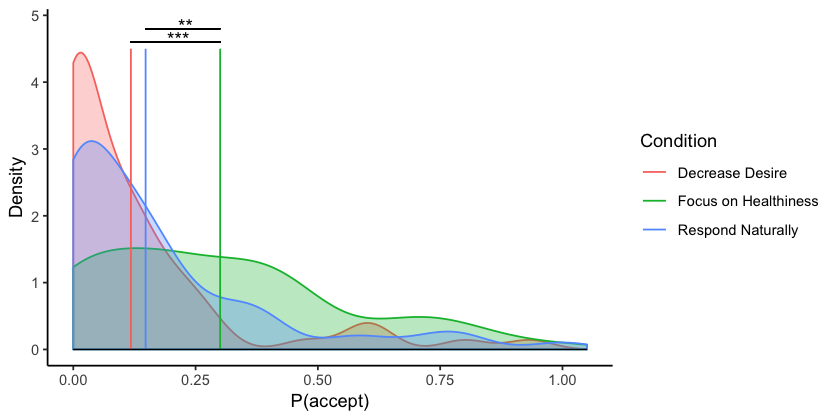

In [213]:
plot = ggplot(accept_hu_sub, aes(x=choice, fill=cond, color=cond)) +
    geom_density(alpha = 0.3, show.legend = F)+
    # vertical mean lines
    geom_segment(data=accept_hu_group, aes(x = choice, y = 0, xend = choice, yend=4.5)) +
    # bottom black line
    geom_segment(data=accept_hu_group, aes(x = 0, y = 0, xend = 1.05, yend=0), color='black', size=0.3) +
    labs(x="P(accept)", y="Density", colour = "Condition") +
   theme_classic()

plot + 
    geom_segment(aes(x = rates$`Respond Naturally`, y = 4.8, 
                        xend = rates$`Focus on Healthiness`, yend = 4.8), size =0.2, color = 'black') +
        annotate("text", x = 0.23, y = 4.85, label = "**", size = 4) +
    geom_segment(aes(x = rates$`Decrease Desire`, y = 4.6, 
                        xend = rates$`Focus on Healthiness`, yend = 4.6), size =0.2, color = 'black') +
        annotate("text", x = 0.215, y = 4.65, label = "***", size = 4) 


#### Statistical Significance

In [156]:
success_dt = dt %>%
    filter(health>3)

In [157]:
accept.lmer <- lmer (choice ~ cond + (1 + cond|subject), data = success_dt)
summaryh(accept.lmer)

term,results
(Intercept),"b = 0.48, SE = 0.03, t(48) = 17.64, p < .001, r = 0.93"
condFocus on Healthiness,"b = 0.09, SE = 0.02, t(47) = 4.12, p < .001, r = 0.52"
condDecrease Desire,"b = −0.20, SE = 0.03, t(49) = −6.18, p < .001, r = 0.66"


In [158]:
anova(lmer (choice ~ cond + (1 + cond|subject), data = hu_dt))

,Sum Sq,Mean Sq,NumDF,DenDF,F value,Pr(>F)
cond,3.774459,1.887229,2,46.80643,16.5627,3.637127e-06


In [159]:
accept.emm = emmeans(accept.lmer, list(pairwise ~ cond), adjust = "tukey")
summary(accept.emm$`pairwise differences of cond`)

Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, set emm_options(pbkrtest.limit = 6176) or larger,
but be warned that this may result in large computation time and memory use.
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, set emm_options(lmerTest.limit = 6176) or larger,
but be warned that this may result in large computation time and memory use.


contrast,estimate,SE,df,z.ratio,p.value
Respond Naturally - Focus on Healthiness,-0.09137644,0.02219871,Inf,-4.116295,1.140186e-04
Respond Naturally - Decrease Desire,0.19532576,0.03158551,Inf,6.184030,1.874088e-09
Focus on Healthiness - Decrease Desire,0.28670220,0.03357016,Inf,8.540387,2.753353e-14


### p(Accept) UnHealthy

#### Means + Plot

##### Violin

cond,N,choice,sd,se,ci
aNaturally,50,0.3946636,0.2256071,0.03190566,0.06411683
bHealthiness,50,0.1706186,0.1518627,0.02147663,0.04315891
cDesire,50,0.1819262,0.1538172,0.02175304,0.04371437


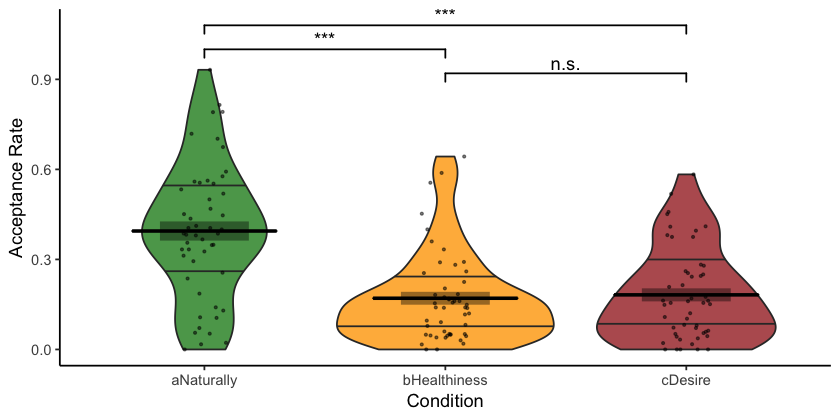

In [258]:
# Acceptance by condition
accept_uh_sub = dt2 %>%
    filter(health<4) %>%
    se(measurevar = "choice", groupvars = c("cond", "subject"))

accept_uh_group = accept_uh_sub %>%
    se(measurevar = "choice", groupvars = c("cond"))

#pander(accept_hu_group)
accept_uh_group


# Plot 
plot = ggplot(accept_uh_sub, aes(cond, choice, fill = cond)) +
    geom_violin(draw_quantiles = c(0.25, 0.75), size=0.5, alpha=0.8, show.legend = F) +
    geom_linerange(aes(ymin = choice-se, ymax = choice+se), size=25, alpha=0.4, data=accept_uh_group) +
    geom_crossbar(stat="summary", fun.y=mean, fun.ymax=mean, fun.ymin=mean, fatten=2, width=0.6, show.legend = F) +
    geom_jitter(height = 0, width = 0.1, size = 0.5, alpha=0.5, show.legend = F) +
    xlab("Condition") +
    ylab("Acceptance Rate") +
    scale_fill_manual(values = c("forestgreen", "orange", "brown")) +
    theme_classic()

plot + 
    geom_signif(annotations = c("n.s.", "***", "***"),
              y_position = c(.92, 1, 1.08), xmin=c(2,1,1), xmax=c(3,2,3))

ggsave("../../3_4_outputs/plots/accept_uh.pdf", width = 20, height = 15, units = "cm")


##### Density

In [236]:
rates = accept_uh_group %>% 
    select('cond', 'choice') %>% 
    spread('cond', 'choice')
rates


Decrease Desire,Focus on Healthiness,Respond Naturally
0.1733643,0.1672402,0.3743151


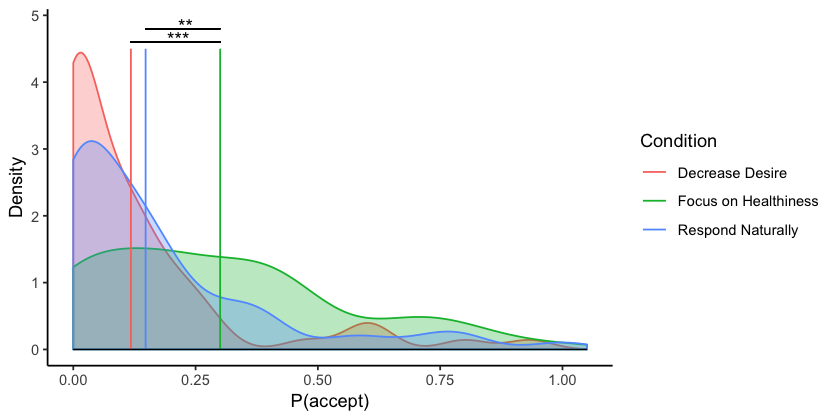

In [213]:
plot = ggplot(accept_hu_sub, aes(x=choice, fill=cond, color=cond)) +
    geom_density(alpha = 0.3, show.legend = F)+
    # vertical mean lines
    geom_segment(data=accept_hu_group, aes(x = choice, y = 0, xend = choice, yend=4.5)) +
    # bottom black line
    geom_segment(data=accept_hu_group, aes(x = 0, y = 0, xend = 1.05, yend=0), color='black', size=0.3) +
    labs(x="P(accept)", y="Density", colour = "Condition") +
   theme_classic()

plot + 
    geom_segment(aes(x = rates$`Respond Naturally`, y = 4.8, 
                        xend = rates$`Focus on Healthiness`, yend = 4.8), size =0.2, color = 'black') +
        annotate("text", x = 0.23, y = 4.85, label = "**", size = 4) +
    geom_segment(aes(x = rates$`Decrease Desire`, y = 4.6, 
                        xend = rates$`Focus on Healthiness`, yend = 4.6), size =0.2, color = 'black') +
        annotate("text", x = 0.215, y = 4.65, label = "***", size = 4) 


#### Statistical Significance

In [160]:
uh_dt = dt %>%
    filter(health<4)

In [161]:
accept.lmer <- lmer (choice ~ cond + (1 + cond|subject), data = uh_dt)
summaryh(accept.lmer)

term,results
(Intercept),"b = 0.39, SE = 0.03, t(49) = 12.34, p < .001, r = 0.87"
condFocus on Healthiness,"b = −0.22, SE = 0.03, t(48) = −7.64, p < .001, r = 0.74"
condDecrease Desire,"b = −0.21, SE = 0.03, t(49) = −7.99, p < .001, r = 0.75"


In [162]:
anova(lmer (choice ~ cond + (1 + cond|subject), data = hu_dt))

,Sum Sq,Mean Sq,NumDF,DenDF,F value,Pr(>F)
cond,3.774459,1.887229,2,46.80643,16.5627,3.637127e-06


In [163]:
accept.emm = emmeans(accept.lmer, list(pairwise ~ cond), adjust = "tukey")
summary(accept.emm$`pairwise differences of cond`)

Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, set emm_options(pbkrtest.limit = 7210) or larger,
but be warned that this may result in large computation time and memory use.
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, set emm_options(lmerTest.limit = 7210) or larger,
but be warned that this may result in large computation time and memory use.


contrast,estimate,SE,df,z.ratio,p.value
Respond Naturally - Focus on Healthiness,0.22349435,0.02925772,Inf,7.6388152,8.404388e-14
Respond Naturally - Decrease Desire,0.21185183,0.02650166,Inf,7.9939088,4.440892e-14
Focus on Healthiness - Decrease Desire,-0.01164252,0.01763179,Inf,-0.6603142,7.864963e-01


# Taste and Health

### Taste: Beta

In [61]:
# Taste by Cond 
taste_weight = se(data = dt_subj, measurevar = "taste_slope", groupvars = "cond")
taste_weight

cond,N,taste_slope,sd,se,ci
Respond Naturally,62,0.3011288,0.1292050,0.01640905,0.03281193
Focus on Healthiness,62,0.1739217,0.1167444,0.01482655,0.02964752
Decrease Desire,62,0.1876460,0.1427019,0.01812316,0.03623951


### Health: Beta

In [62]:
# Health by Cond 
health_weight = se(data = dt_subj, measurevar = "health_slope", groupvars = "cond")
health_weight

cond,N,health_slope,sd,se,ci
Respond Naturally,62,0.03740566,0.07947942,0.010093896,0.02018399
Focus on Healthiness,62,0.21589051,0.15016838,0.019071404,0.03813563
Decrease Desire,62,0.04982649,0.06217192,0.007895842,0.01578871


### Intercept: Beta

In [63]:
# Intercept by Cond 
int = se(data = dt_subj, measurevar = "intercept", groupvars = "cond")
int

cond,N,intercept,sd,se,ci
Respond Naturally,62,2.300485,0.2587082,0.03285597,0.06569958
Focus on Healthiness,62,2.204180,0.2224928,0.02825661,0.05650259
Decrease Desire,62,1.992510,0.2781329,0.03532291,0.07063252


### Health & Taste: Plot Betas

cond,N,beta,sd,se,ci,coef
Respond Naturally,62,0.30112878,0.12920500,0.016409052,0.03281193,taste
Focus on Healthiness,62,0.17392174,0.11674437,0.014826550,0.02964752,taste
Decrease Desire,62,0.18764600,0.14270194,0.018123165,0.03623951,taste
Respond Naturally,62,0.03740566,0.07947942,0.010093896,0.02018399,health
Focus on Healthiness,62,0.21589051,0.15016838,0.019071404,0.03813563,health
Decrease Desire,62,0.04982649,0.06217192,0.007895842,0.01578871,health


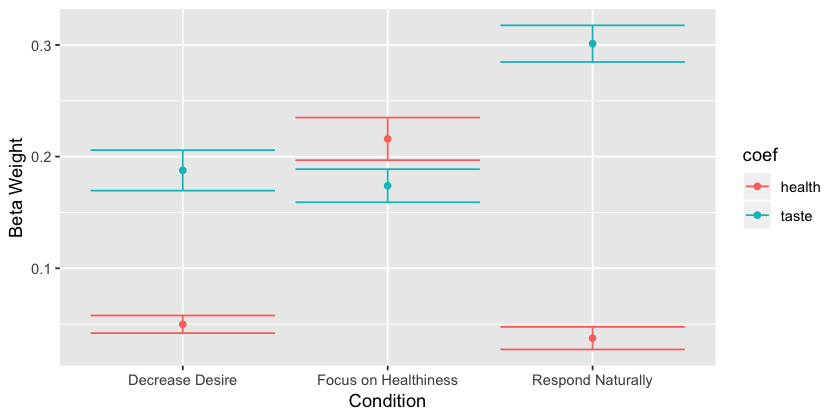

In [64]:
# Plot Simultaneously
# standardize column names and add coef column
taste_weight$coef = 'taste'
taste_weight = taste_weight%>%
  rename(beta = taste_slope)
health_weight$coef = 'health'
health_weight = health_weight%>%
  rename(beta = health_slope)
# int$coef = 'intercept'
# int = int%>%
#   rename(beta = intercept)

# Stack
combined <- rbind(taste_weight, health_weight)
combined

# Plot
ggplot(combined, aes(cond, beta, color = coef)) +
  geom_point() +
  geom_errorbar(aes(ymin = beta-se, ymax = beta+se)) +
    xlab("Condition") +
    ylab("Beta Weight")

### Taste: Statistical Significance

In [39]:
taste.lm <- lm(taste_slope ~ cond, data = dt_subj)
summaryh(taste.lm)

term,results
(Intercept),"b = 0.30, SE = 0.02, t(183) = 18.24, p < .001, r = 0.80"
condFocus on Healthiness,"b = −0.13, SE = 0.02, t(183) = −5.45, p < .001, r = 0.37"
condDecrease Desire,"b = −0.11, SE = 0.02, t(183) = −4.86, p < .001, r = 0.34"


In [42]:
taste.emm = emmeans(taste.lm, list(pairwise ~ cond), adjust = "tukey")
summary(taste.emm$`pairwise differences of cond`)

contrast,estimate,SE,df,t.ratio,p.value
Respond Naturally - Focus on Healthiness,0.12720704,0.0233457,183,5.4488421,4.847431e-07
Respond Naturally - Decrease Desire,0.11348278,0.0233457,183,4.8609712,7.461746e-06
Focus on Healthiness - Decrease Desire,-0.01372426,0.0233457,183,-0.5878709,8.267959e-01


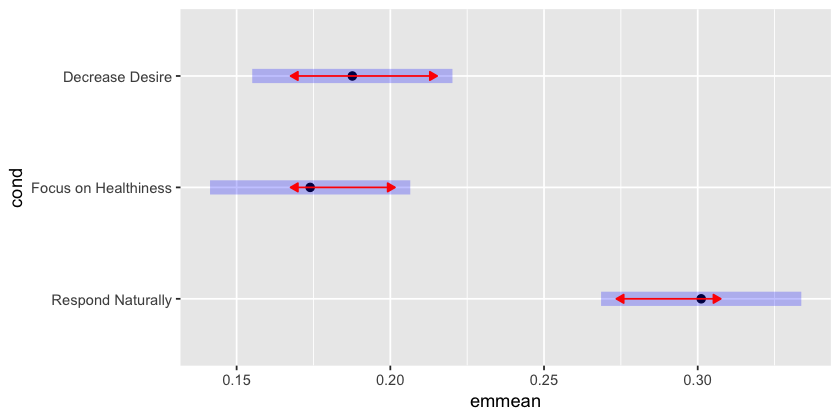

In [43]:
plot(taste.emm, comparisons = TRUE)

### Health: Statistical Significance

In [45]:
health.lm <- lm(health_slope ~ cond, data = dt_subj)
summaryh(taste.lm)

term,results
(Intercept),"b = 0.30, SE = 0.02, t(183) = 18.24, p < .001, r = 0.80"
condFocus on Healthiness,"b = −0.13, SE = 0.02, t(183) = −5.45, p < .001, r = 0.37"
condDecrease Desire,"b = −0.11, SE = 0.02, t(183) = −4.86, p < .001, r = 0.34"


In [48]:
health.emm = emmeans(health.lm, list(pairwise ~ cond), adjust = "tukey")
summary(health.emm$`pairwise differences of cond`)


contrast,estimate,SE,df,t.ratio,p.value
Respond Naturally - Focus on Healthiness,-0.17848485,0.01876077,183,-9.5137295,0.00000000000006517009
Respond Naturally - Decrease Desire,-0.01242084,0.01876077,183,-0.6620644,0.78574642056740140461
Focus on Healthiness - Decrease Desire,0.16606402,0.01876077,183,8.8516651,0.00000000000006517009


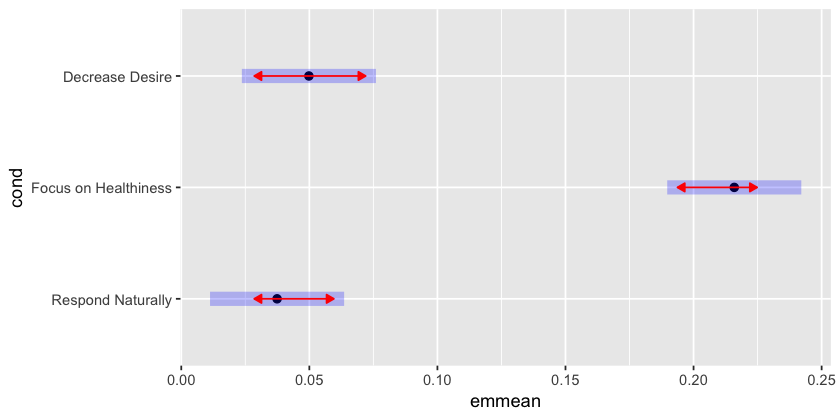

In [49]:
plot(health.emm, comparisons = TRUE)

# Post/Pre

### Main Effect by Condition

In [247]:
post_pre_sub = dt2 %>%
    group_by(subject, cond) %>%
    summarise(mean_pp = mean(post_pre)) %>%
    select(subject, cond, mean_pp)


#### Means + Plot

##### Violin

cond,N,mean_pp,sd,se,ci
aNaturally,50,-0.1662449,0.4726617,0.06684447,0.1343290
bHealthiness,50,-0.1751450,0.4441475,0.06281194,0.1262253
cDesire,50,-0.2378387,0.4607611,0.06516145,0.1309468


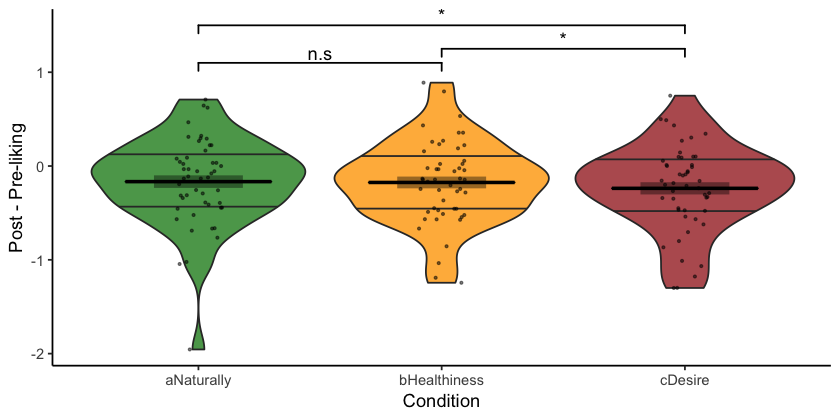

In [259]:
post_pre_group = post_pre_sub %>%
    se(measurevar = "mean_pp", groupvars = c("cond"))

#pander(ddm_taste_group)
post_pre_group


# Plot 
plot = ggplot(post_pre_sub, aes(cond, mean_pp, fill = cond)) +
    geom_violin(draw_quantiles = c(0.25, 0.75), size=0.5, alpha=0.8, show.legend = F) +
    geom_linerange(aes(ymin = mean_pp-se, ymax = mean_pp+se), size=25, alpha=0.4, data=post_pre_group) +
    geom_crossbar(stat="summary", fun.y=mean, fun.ymax=mean, fun.ymin=mean, fatten=2, width=0.6, show.legend = F) +
    geom_jitter(height = 0, width = 0.1, size = 0.5, alpha=0.5, show.legend = F) +
    xlab("Condition") +
    ylab("Post - Pre-liking") +
    scale_fill_manual(values = c("forestgreen", "orange", "brown")) +
    theme_classic()

plot + 
    geom_signif(annotations = c("n.s", "*", "*"),
              y_position = c(1.1, 1.25, 1.5), xmin=c(1,2,1), xmax=c(2,3,3))

ggsave("../../3_4_outputs/plots/post-pre_me.pdf", width = 20, height = 15, units = "cm")


#### Statistical Significance

In [171]:
pp.aov = aov(mean_pp ~ cond + Error(subject), 
             contrasts = list(cond = "contr.sum"),
             data = post_pre_sub)
             
summary(pp.aov)


Error: subject
          Df Sum Sq Mean Sq F value Pr(>F)
Residuals 49  29.44  0.6007               

Error: Within
          Df Sum Sq Mean Sq F value Pr(>F)  
cond       2 0.1523 0.07613   4.723  0.011 *
Residuals 98 1.5797 0.01612                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [167]:
pp.emm = emmeans(pp.aov, list(pairwise ~ cond), adjust = "tukey")
summary(pp.emm$`pairwise differences of cond`)

contrast,estimate,SE,df,t.ratio,p.value
Respond Naturally - Focus on Healthiness,0.008900043,0.02539258,98,0.3504977,0.93457314
Respond Naturally - Decrease Desire,0.071593775,0.02539258,98,2.8194758,0.01591520
Focus on Healthiness - Decrease Desire,0.062693732,0.02539258,98,2.4689781,0.04016389


### Healthy Foods

In [251]:
post_preH_sub = dt2 %>%
    filter(health>3) %>%
    group_by(subject, cond) %>%
    summarise(mean_pp = mean(post_pre)) %>%
    select(subject, cond, mean_pp)


#### Means + Plot

##### Violin

cond,N,mean_pp,sd,se,ci
aNaturally,50,-0.1886474,0.4857566,0.06869636,0.1380505
bHealthiness,50,-0.1295505,0.4434985,0.06272015,0.1260409
cDesire,50,-0.2600749,0.5325042,0.07530746,0.1513360


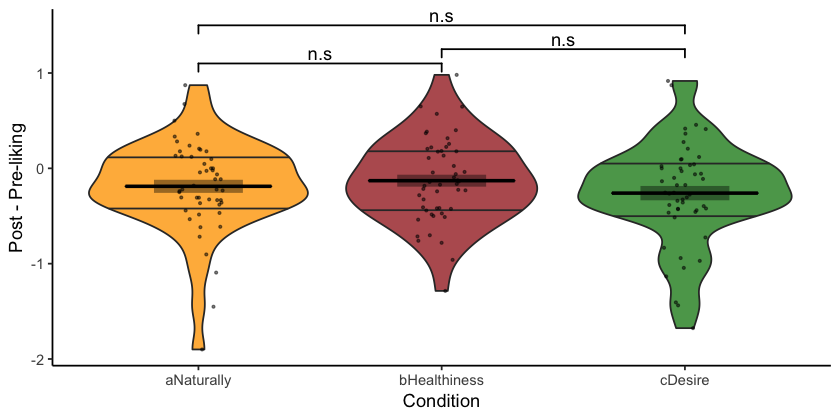

In [254]:
post_preH_group = post_preH_sub %>%
    se(measurevar = "mean_pp", groupvars = c("cond"))

#pander(ddm_taste_group)
post_preH_group


# Plot 
plot = ggplot(post_preH_sub, aes(cond, mean_pp, fill = cond)) +
    geom_violin(draw_quantiles = c(0.25, 0.75), size=0.5, alpha=0.8, show.legend = F) +
    geom_linerange(aes(ymin = mean_pp-se, ymax = mean_pp+se), size=25, alpha=0.4, data=post_preH_group) +
    geom_crossbar(stat="summary", fun.y=mean, fun.ymax=mean, fun.ymin=mean, fatten=2, width=0.6, show.legend = F) +
    geom_jitter(height = 0, width = 0.1, size = 0.5, alpha=0.5, show.legend = F) +
    xlab("Condition") +
    ylab("Post - Pre-liking") +
    scale_fill_manual(values = c("orange", "brown", "forestgreen")) +
    theme_classic()

plot + 
    geom_signif(annotations = c("n.s", "n.s", "n.s"),
              y_position = c(1.1, 1.25, 1.5), xmin=c(1,2,1), xmax=c(2,3,3))

ggsave("../../3_4_outputs/plots/post-pre_healthy.pdf", width = 20, height = 15, units = "cm")

#### Statistical Significance

In [183]:
pp.aov = aov(mean_pp ~ cond + Error(subject), 
             contrasts = list(cond = "contr.sum"),
             data = post_preH_sub)
summary(pp.aov)


Error: subject
          Df Sum Sq Mean Sq F value Pr(>F)
Residuals 49  30.91  0.6307               

Error: Within
          Df Sum Sq Mean Sq F value  Pr(>F)   
cond       2  0.427 0.21359   4.996 0.00859 **
Residuals 98  4.190 0.04275                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [184]:
pp.emm = emmeans(pp.aov, list(pairwise ~ cond), adjust = "tukey")
summary(pp.emm$`pairwise differences of cond`)

contrast,estimate,SE,df,t.ratio,p.value
aNaturally - bHealthiness,-0.05909686,0.04135216,98,-1.429112,0.330003110
aNaturally - cDesire,0.07142750,0.04135216,98,1.727298,0.200211527
bHealthiness - cDesire,0.13052436,0.04135216,98,3.156409,0.005963993


### UnHealthy Foods

In [189]:
post_preUH_sub = dt2 %>%
    filter(health<4) %>%
    group_by(subject, cond) %>%
    summarise(mean_pp = mean(post_pre)) %>%
    select(subject, cond, mean_pp)

#### Means + Plot

##### Violin

cond,N,mean_pp,sd,se,ci
aNaturally,50,-0.1536504,0.5701604,0.08063286,0.1620378
bHealthiness,50,-0.2069256,0.5574445,0.07883455,0.1584240
cDesire,50,-0.2164295,0.5072735,0.07173930,0.1441655


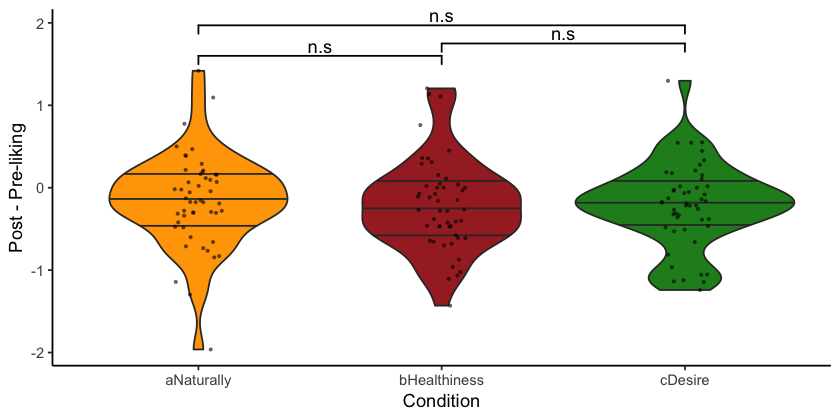

In [190]:
post_preUH_group = post_preUH_sub %>%
    se(measurevar = "mean_pp", groupvars = c("cond"))

#pander(ddm_taste_group)
post_preUH_group


# Plot 
plot = ggplot(post_preUH_sub, aes(cond, mean_pp, fill = cond)) +
    geom_violin(draw_quantiles = c(0.25, 0.5, 0.75), size=0.5, alpha=1, show.legend = F) + #draw_quantiles = c(0.5)
    #geom_errorbar(aes(ymin = choice-se, ymax = choice+se), width=0.2, data=accept_rate_group) +
    #geom_boxplot(width = .3) +
    geom_jitter(height = 0, width = 0.1, size = 0.5, alpha=0.5, show.legend = F) +
    xlab("Condition") +
    ylab("Post - Pre-liking") +
    scale_fill_manual(values = c("orange", "brown", "forestgreen")) +
    theme_classic()

plot + 
    geom_signif(annotations = c("n.s", "n.s", "n.s"),
              y_position = c(1.6, 1.75, 1.97), xmin=c(1,2,1), xmax=c(2,3,3))

ggsave("../../3_4_outputs/plots/post-pre_unhealthy.pdf", width = 20, height = 15, units = "cm")

#### Statistical Significance

In [191]:
pp.aov = aov(mean_pp ~ cond + Error(subject),
             contrasts = list(cond = "contr.sum"),
             data = post_preUH_sub)
summary(pp.aov)


Error: subject
          Df Sum Sq Mean Sq F value Pr(>F)
Residuals 49  40.64  0.8293               

Error: Within
          Df Sum Sq Mean Sq F value Pr(>F)
cond       2 0.1145 0.05725   1.794  0.172
Residuals 98 3.1273 0.03191               

In [192]:
pp.emm = emmeans(pp.aov, list(pairwise ~ cond), adjust = "tukey")
summary(pp.emm$`pairwise differences of cond`)

contrast,estimate,SE,df,t.ratio,p.value
aNaturally - bHealthiness,0.05327521,0.03572721,98,1.4911663,0.2995719
aNaturally - cDesire,0.06277910,0.03572721,98,1.7571789,0.1895222
bHealthiness - cDesire,0.00950389,0.03572721,98,0.2660126,0.9617583


### Success: Healthy - Unhealthy Foods

In [66]:
post_preH_sub = dt2 %>%
    filter(health>3) %>%
    group_by(subject, cond) %>%
    summarise(mean_pp = mean(post_pre)) %>%
    select(subject, cond, mean_pp)

In [193]:
post_preUH_sub = dt2 %>%
    filter(health<4) %>%
    group_by(subject, cond) %>%
    summarise(mean_pp = mean(post_pre)) %>%
    select(subject, cond, mean_pp)

In [194]:
post_preSuccess_sub = post_preH_sub
post_preSuccess_sub$mean_pp = post_preH_sub$mean_pp - post_preUH_sub$mean_pp

#### Means + Plot

##### Violin

cond,N,mean_pp,sd,se,ci
aNaturally,50,-0.03499698,0.4412710,0.06240514,0.1254078
bHealthiness,50,0.07737509,0.5104651,0.07219066,0.1450726
cDesire,50,-0.04364538,0.4133461,0.05845597,0.1174717


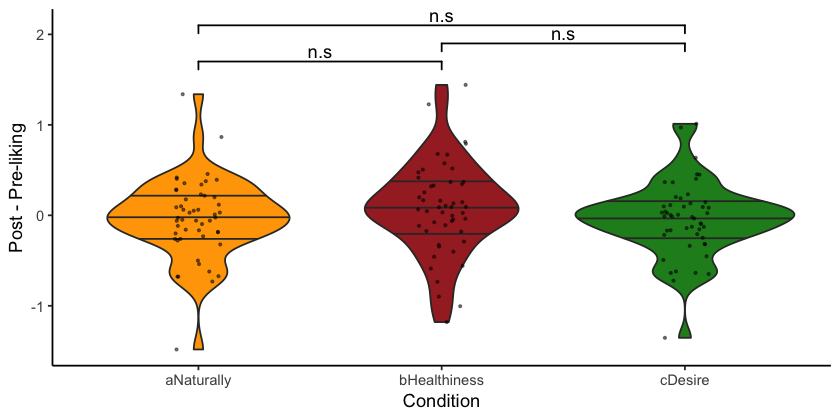

In [195]:
post_preSuccess_group = post_preSuccess_sub %>%
    se(measurevar = "mean_pp", groupvars = c("cond"))

#pander(ddm_taste_group)
post_preSuccess_group


# Plot 
plot = ggplot(post_preSuccess_sub, aes(cond, mean_pp, fill = cond)) +
    geom_violin(draw_quantiles = c(0.25, 0.5, 0.75), size=0.5, alpha=1, show.legend = F) + #draw_quantiles = c(0.5)
    #geom_errorbar(aes(ymin = choice-se, ymax = choice+se), width=0.2, data=accept_rate_group) +
    #geom_boxplot(width = .3) +
    geom_jitter(height = 0, width = 0.1, size = 0.5, alpha=0.5, show.legend = F) +
    xlab("Condition") +
    ylab("Post - Pre-liking") +
    scale_fill_manual(values = c("orange", "brown", "forestgreen")) +
    theme_classic()

plot + 
    geom_signif(annotations = c("n.s", "n.s", "n.s"),
              y_position = c(1.7, 1.9, 2.1), xmin=c(1,2,1), xmax=c(2,3,3))

ggsave("../../3_4_outputs/plots/post-pre_healthy.pdf", width = 20, height = 15, units = "cm")

#### Statistical Significance

In [197]:
pp.aov = aov(mean_pp ~ cond + Error(subject),
             contrasts = list(cond = "contr.sum"),
             data = post_preSuccess_sub)
summary(pp.aov)


Error: subject
          Df Sum Sq Mean Sq F value Pr(>F)
Residuals 49  23.08  0.4711               

Error: Within
          Df Sum Sq Mean Sq F value Pr(>F)  
cond       2  0.456 0.22790   2.939 0.0576 .
Residuals 98  7.599 0.07754                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [198]:
pp.emm = emmeans(pp.aov, list(pairwise ~ cond), adjust = "tukey")
summary(pp.emm$`pairwise differences of cond`)

contrast,estimate,SE,df,t.ratio,p.value
aNaturally - bHealthiness,-0.112372068,0.05569154,98,-2.0177583,0.11330666
aNaturally - cDesire,0.008648399,0.05569154,98,0.1552911,0.98679498
bHealthiness - cDesire,0.121020467,0.05569154,98,2.1730494,0.08093172


### Predicting Post/Pre

---
Looking just at the **Focus on Healthiness** condition

---

#### Health Cond: Regulatory Success ~ $\Delta$Health Weight + $\Delta$Taste Weight

In [169]:
hw = dt_subj %>% 
    filter(cond == "Focus on Healthiness") %>% 
    select(subject, cond, health_slope_change)

tw = dt_subj %>% 
    filter(cond == "Focus on Healthiness") %>% 
    select(subject, cond, taste_slope_change)

In [170]:
#PostPre Liking change in for HEALTHY vs UNHEALTHY foods from Health Condition
pp_healthy = dt %>%
  group_by(subject) %>%
  summarise(change = mean(post_pre[cond=="Focus on Healthiness" & healthy=="healthy"], na.rm = TRUE))

pp_unhealthy = dt %>%
  group_by(subject) %>%
  summarise(change = mean(post_pre[cond=="Focus on Healthiness" & healthy=="unhealthy"], na.rm = TRUE))

reg_success = pp_healthy %>% select(-change)
reg_success$successful_lasting_change = pp_healthy$change - pp_unhealthy$change
reg_success$hw = hw$health_slope_change
reg_success$tw = tw$taste_slope_change
reg_success$successful_reweighting = hw$health_slope_change - tw$taste_slope_change

In [171]:
# save for 
saveRDS(reg_success, "../data/reg_success_lasting.rds")

##### Statistical Sig

In [177]:
m = lm(successful_lasting_change~successful_reweighting, data=reg_success)
summary(m)


Call:
lm(formula = successful_lasting_change ~ successful_reweighting, 
    data = reg_success)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.20532 -0.22197 -0.00919  0.20466  1.15784 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)   
(Intercept)            -0.13671    0.08991  -1.520  0.13364   
successful_reweighting  0.66476    0.22190   2.996  0.00398 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4647 on 60 degrees of freedom
Multiple R-squared:  0.1301,	Adjusted R-squared:  0.1156 
F-statistic: 8.974 on 1 and 60 DF,  p-value: 0.003976


In [180]:
m = lm(successful_lasting_change~hw*tw, data=reg_success)
summary(m)


Call:
lm(formula = successful_lasting_change ~ hw * tw, data = reg_success)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.26518 -0.17212 -0.03592  0.26209  1.19589 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)  
(Intercept)  -0.1724     0.1077  -1.601   0.1147  
hw            1.9751     0.7749   2.549   0.0135 *
tw            1.3848     0.9046   1.531   0.1312  
hw:tw        -1.6270     2.2583  -0.720   0.4741  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4475 on 58 degrees of freedom
Multiple R-squared:  0.2201,	Adjusted R-squared:  0.1798 
F-statistic: 5.456 on 3 and 58 DF,  p-value: 0.002256


##### Plot

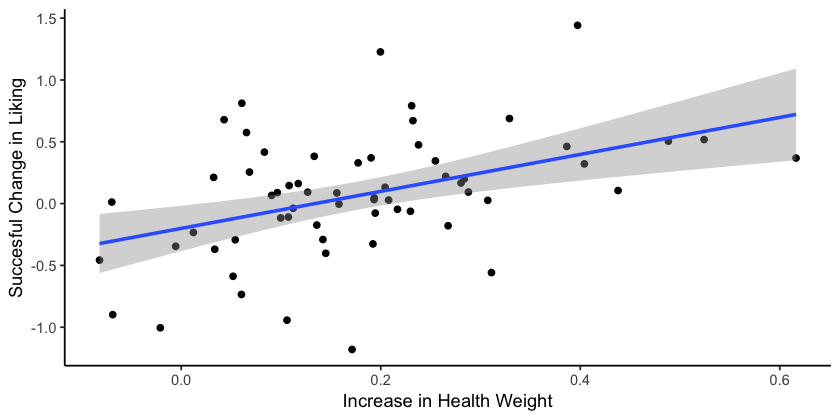

In [182]:
ggplot(reg_success, aes(hw, successful_lasting_change)) +
    geom_point() +
    geom_smooth(method = "lm") +
#    xlab(expression(Delta*" Health Weight (in Health condition)")) +
    xlab("Increase in Health Weight") +
    ylab("Succesful Change in Liking") +
    theme_classic()

ggsave("../../3_4_outputs/plots/sreg.pdf", width = 20, height = 15, units = "cm")

The line in blue is the best-fit line, with 95% confidence intervals in grey indicating a range of values so defined that there is a 95% probability that the true value of a parameter lies within it.

#### Decrease Cond: Regulatory Success ~ $\Delta$Health Weight + $\Delta$Taste Weight

In [38]:
# Health weight CHANGE in health condition 
hw = dt_subj$health_slope_change[dt_subj$cond=="Decrease Desire"]
tw = dt_subj$taste_slope_change[dt_subj$cond=="Decrease Desire"]

#vs 
#PostPre Liking change in Decrease Condition
reg_success = dt %>%
  group_by(subject) %>%
  summarise(change = mean(post_pre[cond=="Decrease Desire"], na.rm = TRUE))

reg_success$hw = hw
reg_success$tw = tw

##### Statistical Significance

In [39]:
m = lm(change~hw + tw, data=reg_success)
summary(m)


Call:
lm(formula = change ~ hw + tw, data = reg_success)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.54700 -0.24402  0.05012  0.31984  1.01375 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)   
(Intercept) -0.27075    0.08029  -3.372  0.00132 **
hw           0.69141    1.01713   0.680  0.49931   
tw          -0.02208    0.41428  -0.053  0.95768   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.502 on 59 degrees of freedom
Multiple R-squared:  0.007807,	Adjusted R-squared:  -0.02583 
F-statistic: 0.2321 on 2 and 59 DF,  p-value: 0.7936


#### Decrease: Plot

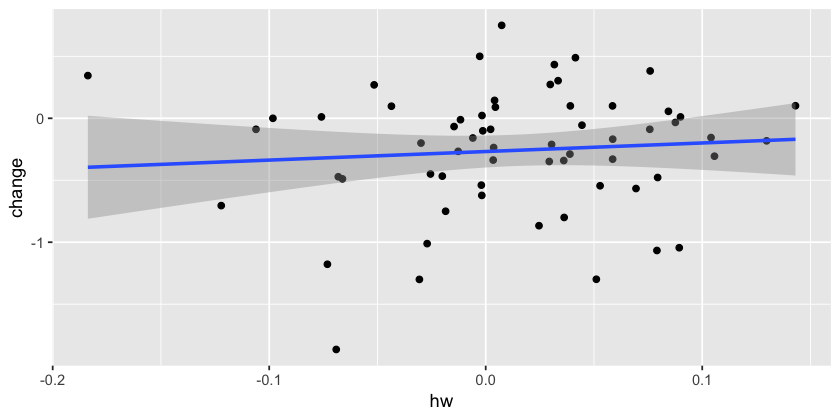

In [40]:
ggplot(reg_success, aes(hw, change)) +
  geom_point() +
  geom_smooth(method = "lm")

# DDM

## Base

In [3]:
# load data
df_ddm = read_csv("../data/DDM_ParameterEstimates_Bayes.csv")
df_ddm_constant = read_csv("../ddm/DDMAnalysis_ConstantModel/DDM_ParameterEstimates_Bayes.csv")

ERROR: Error: '../data/DDM_ParameterEstimates_Bayes.csv' does not exist in current working directory ('/Users/djw/Documents/pCloud_synced/Academics/PROJECTS/2018_FoodReg/3_experiment/3_3_data_analysis').


In [79]:
dim(df_ddm_constant)[1]

[1] 45

In [78]:
# Remove rejected subjects 

good_subjects = c(101:104, 106:112, 114, 116, 118:121, 123:126, 129:137, 139:140, 142:148, 150, 152:158, 162:164)
# remove "bad" subjects
df_ddm_constant = df_ddm_constant %>%
    filter(Subject %in% good_subjects)

In [76]:
head(df_ddm_constant, 3)

Subject,Taste_Nat,Health_Nat,Threshold_Nat,StBias_Nat,NonDec_Nat,Taste_Health,Health_Health,Threshold_Health,StBias_Health,⋯,TasteChange_Nat,HealthChange_Nat,LikingChange_Health,InterceptChange_Health,TasteChange_Health,HealthChange_Health,LikingChange_Desire,InterceptChange_Desire,TasteChange_Desire,HealthChange_Desire
101,0.0631,0.0280,0.0682,-0.2868,0.5615,0.0222,0.0785,0.0628,-0.2571,⋯,0.0468,0.1232,-0.2386,-0.6082,0.0400,0.0536,-0.2159,-0.2875,0.0370,-0.0186
102,0.0585,-0.0045,0.0898,-0.1555,0.3260,0.0305,0.0386,0.1147,-0.2415,⋯,-0.1534,-0.0752,-0.4667,-0.5110,0.0443,-0.0143,-0.3523,0.0792,-0.1399,-0.0436
103,0.0374,0.0266,0.0820,-0.1555,0.3884,0.0334,0.0221,0.0832,-0.1655,⋯,0.0916,-0.2301,-0.0455,0.9144,0.0946,-0.3845,-0.0889,0.1790,0.2342,-0.3125


### Taste Weight

In [22]:
ddm_taste_sub = df_ddm %>%
    select(Subject, Taste_Nat, Taste_Health, Taste_Desire) %>%
    gather("Taste_Nat", "Taste_Health", "Taste_Desire",
          key = "cond", value = "weight")

head(ddm_taste_sub, 3)

Subject,cond,weight
101,Taste_Nat,0.0631
102,Taste_Nat,0.0585
103,Taste_Nat,0.0374


In [23]:
ddm_taste_sub$cond = plyr::mapvalues(ddm_taste_sub$cond, 
          from = c("Taste_Nat", "Taste_Health", "Taste_Desire"),
          to = c("aNaturally", "bHealthiness", "cDesire"))

#### Means + Plot

##### Violin

cond,N,weight,sd,se,ci
aNaturally,55,0.04077455,0.02536235,0.003419858,0.006856403
bHealthiness,55,0.02028909,0.01923686,0.002593898,0.005200453
cDesire,55,0.01722000,0.02221800,0.002995874,0.006006366


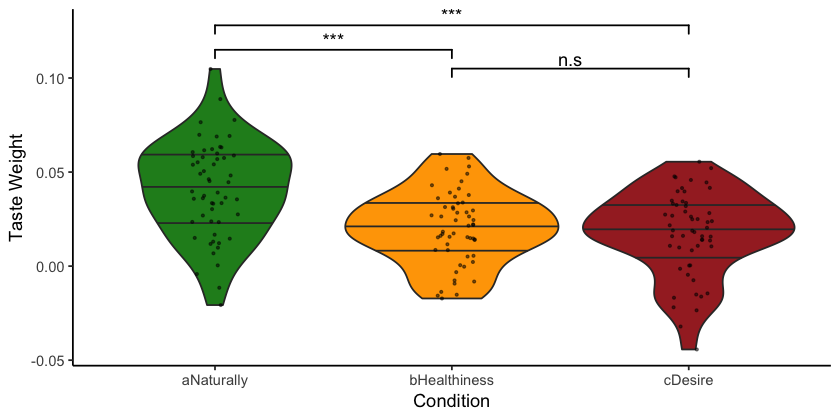

In [24]:
ddm_taste_group = ddm_taste_sub %>%
    se(measurevar = "weight", groupvars = c("cond"))

#pander(ddm_taste_group)
ddm_taste_group


# Plot 
plot = ggplot(ddm_taste_sub, aes(cond, weight, fill = cond)) +
    geom_violin(draw_quantiles = c(0.25, 0.5, 0.75), size=0.5, alpha=1, show.legend = F) + #draw_quantiles = c(0.5)
    #geom_errorbar(aes(ymin = choice-se, ymax = choice+se), width=0.2, data=accept_rate_group) +
    #geom_boxplot(width = .3) +
    geom_jitter(height = 0, width = 0.1, size = 0.5, alpha=0.5, show.legend = F) +
    xlab("Condition") +
    ylab("Taste Weight") +
    scale_fill_manual(values = c("forestgreen", "orange", "brown")) +
    theme_classic()

plot + 
    geom_signif(annotations = c("n.s", "***", "***"),
              y_position = c(.105, .115, .128), xmin=c(2,1,1), xmax=c(3,2,3))

ggsave("../../3_4_outputs/plots/ddm_taste.pdf", width = 20, height = 15, units = "cm")

#### Statistical Significance

In [261]:
taste.aov = aov(weight ~ cond, data = ddm_taste_sub)
summaryh(taste.aov)

term,results
cond,"F(2, 162) = 17.95, p < .001, r = 0.43"


In [262]:
taste.emm = emmeans(taste.aov, list(pairwise ~ cond), adjust = "tukey")
summary(taste.emm$`pairwise differences of cond`)

contrast,estimate,SE,df,t.ratio,p.value
Taste_Desire - Taste_Health,-0.003069091,0.004273874,162,-0.7181051,7.531436e-01
Taste_Desire - Taste_Nat,-0.023554545,0.004273874,162,-5.5112868,4.119127e-07
Taste_Health - Taste_Nat,-0.020485455,0.004273874,162,-4.7931817,1.098381e-05


### Health Weight

In [25]:
ddm_health_sub = df_ddm %>%
    select(Subject, Health_Nat, Health_Health, Health_Desire) %>%
    gather("Health_Nat", "Health_Health", "Health_Desire",
          key = "cond", value = "weight")

ddm_health_sub$cond = plyr::mapvalues(ddm_health_sub$cond, 
          from = c("Health_Nat", "Health_Health", "Health_Desire"),
          to = c("aNaturally", "bHealthiness", "cDesire"))

head(ddm_health_sub, 3)

Subject,cond,weight
101,aNaturally,0.0280
102,aNaturally,-0.0045
103,aNaturally,0.0266


#### Means + Plot

##### Violin

cond,N,weight,sd,se,ci
aNaturally,55,0.006698182,0.01644253,0.002217111,0.004445039
bHealthiness,55,0.036158182,0.02724204,0.003673316,0.007364555
cDesire,55,0.009869091,0.01702835,0.002296102,0.004603408


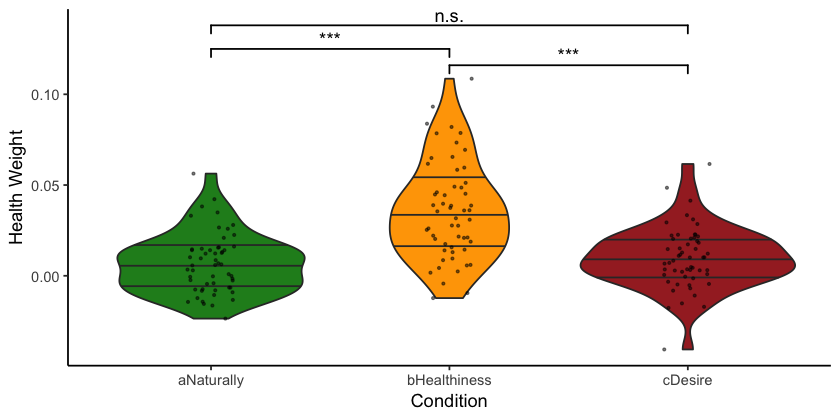

In [26]:
ddm_health_group = ddm_health_sub %>%
    se(measurevar = "weight", groupvars = c("cond"))

#pander(ddm_taste_group)
ddm_health_group


# Plot 
plot = ggplot(ddm_health_sub, aes(cond, weight, fill = cond)) +
    geom_violin(draw_quantiles = c(0.25, 0.5, 0.75), size=0.5, alpha=1, show.legend = F) + #draw_quantiles = c(0.5)
    #geom_errorbar(aes(ymin = choice-se, ymax = choice+se), width=0.2, data=accept_rate_group) +
    #geom_boxplot(width = .3) +
    geom_jitter(height = 0, width = 0.1, size = 0.5, alpha=0.5, show.legend = F) +
    xlab("Condition") +
    ylab("Health Weight") +
    scale_fill_manual(values = c("forestgreen", "orange", "brown")) +
    theme_classic()

plot + 
    geom_signif(annotations = c("***", "***", "n.s."),
              y_position = c(.116, .125, .138), xmin=c(2,1,1), xmax=c(3,2,3))

ggsave("../../3_4_outputs/plots/ddm_health.pdf", width = 20, height = 15, units = "cm")

#### Statistical Significance

In [273]:
health.aov = aov(weight ~ cond, data = ddm_health_sub)
summaryh(health.aov)

term,results
cond,"F(2, 162) = 33.13, p < .001, r = 0.54"


In [274]:
health.emm = emmeans(health.aov, list(pairwise ~ cond), adjust = "tukey")
summary(health.emm$`pairwise differences of cond`)

contrast,estimate,SE,df,t.ratio,p.value
Health_Desire - Health_Health,-0.026289091,0.003973321,162,-6.6164030,1.533757e-09
Health_Desire - Health_Nat,0.003170909,0.003973321,162,0.7980501,7.047563e-01
Health_Health - Health_Nat,0.029460000,0.003973321,162,7.4144531,1.944489e-11


### Boundary

In [27]:
head(df_ddm, 3)

Subject,Taste_Nat,Health_Nat,Threshold_Nat,StBias_Nat,NonDec_Nat,Taste_Health,Health_Health,Threshold_Health,StBias_Health,⋯,TasteChange_Nat,HealthChange_Nat,LikingChange_Health,InterceptChange_Health,TasteChange_Health,HealthChange_Health,LikingChange_Desire,InterceptChange_Desire,TasteChange_Desire,HealthChange_Desire
101,0.0631,0.0280,0.0682,-0.2868,0.5615,0.0222,0.0785,0.0628,-0.2571,⋯,0.0468,0.1232,-0.2386,-0.6082,0.0400,0.0536,-0.2159,-0.2875,0.0370,-0.0186
102,0.0585,-0.0045,0.0898,-0.1555,0.3260,0.0305,0.0386,0.1147,-0.2415,⋯,-0.1534,-0.0752,-0.4667,-0.5110,0.0443,-0.0143,-0.3523,0.0792,-0.1399,-0.0436
103,0.0374,0.0266,0.0820,-0.1555,0.3884,0.0334,0.0221,0.0832,-0.1655,⋯,0.0916,-0.2301,-0.0455,0.9144,0.0946,-0.3845,-0.0889,0.1790,0.2342,-0.3125


In [28]:
ddm_bound_sub = df_ddm %>%
    select(Subject, Threshold_Nat, Threshold_Health, Threshold_Desire) %>%
    gather("Threshold_Nat", "Threshold_Health", "Threshold_Desire",
          key = "cond", value = "bound")

# remove outlier
ddm_bound_sub = ddm_bound_sub %>%
    filter(bound<0.3)

head(ddm_bound_sub, 3)

Subject,cond,bound
101,Threshold_Nat,0.0682
102,Threshold_Nat,0.0898
103,Threshold_Nat,0.0820


#### Means + Plot

##### Violin

cond,N,bound,sd,se,ci
Threshold_Desire,54,0.1105204,0.02591486,0.003526565,0.007073394
Threshold_Health,54,0.1061537,0.02352246,0.003201002,0.006420397
Threshold_Nat,55,0.1002473,0.02179060,0.002938244,0.005890825


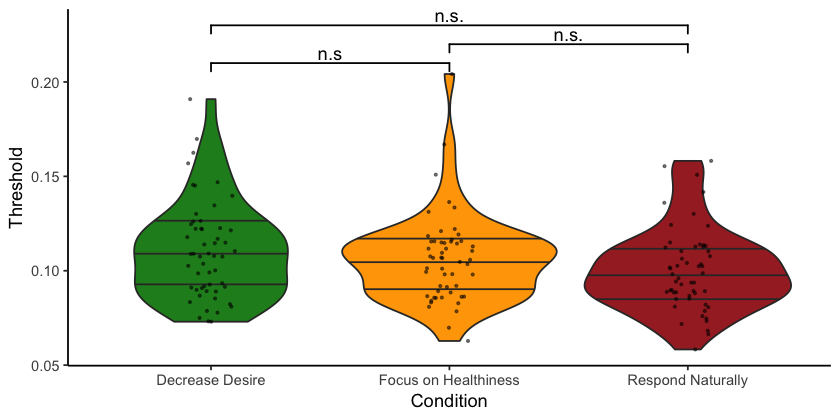

In [29]:
ddm_bound_group = ddm_bound_sub %>%
    se(measurevar = "bound", groupvars = c("cond"))

#pander(ddm_taste_group)
ddm_bound_group


# Plot 
plot = ggplot(ddm_bound_sub, aes(cond, bound, fill = cond)) +
    geom_violin(draw_quantiles = c(0.25, 0.5, 0.75), size=0.5, alpha=1, show.legend = F) + #draw_quantiles = c(0.5)
    #geom_errorbar(aes(ymin = choice-se, ymax = choice+se), width=0.2, data=accept_rate_group) +
    #geom_boxplot(width = .3) +
    geom_jitter(height = 0, width = 0.1, size = 0.5, alpha=0.5, show.legend = F) +
    xlab("Condition") +
    ylab("Threshold") +
    scale_fill_manual(values = c("forestgreen", "orange", "brown")) +
    scale_x_discrete(labels = c('Decrease Desire','Focus on Healthiness','Respond Naturally')) +
    theme_classic()

plot + 
    geom_signif(annotations = c("n.s", "n.s.", "n.s."),
              y_position = c(.21, .22, .23), xmin=c(1,2,1), xmax=c(2,3,3))

ggsave("../../3_4_outputs/plots/ddm_bound.pdf", width = 20, height = 15, units = "cm")

#### Statistical Significance

In [288]:
bound.aov = aov(bound ~ cond, data = ddm_bound_sub)
summaryh(bound.aov)

term,results
cond,"F(2, 160) = 2.56, p = .080, r = 0.18"


In [289]:
bound.emm = emmeans(bound.aov, list(pairwise ~ cond), adjust = "tukey")
summary(bound.emm$`pairwise differences of cond`)

contrast,estimate,SE,df,t.ratio,p.value
Threshold_Desire - Threshold_Health,0.004366667,0.004578528,160,0.9537272,0.60715674
Threshold_Desire - Threshold_Nat,0.010273098,0.004557669,160,2.2540246,0.06544397
Threshold_Health - Threshold_Nat,0.005906431,0.004557669,160,1.2959325,0.39954675


### SP Bias

In [30]:
head(df_ddm, 3)

Subject,Taste_Nat,Health_Nat,Threshold_Nat,StBias_Nat,NonDec_Nat,Taste_Health,Health_Health,Threshold_Health,StBias_Health,⋯,TasteChange_Nat,HealthChange_Nat,LikingChange_Health,InterceptChange_Health,TasteChange_Health,HealthChange_Health,LikingChange_Desire,InterceptChange_Desire,TasteChange_Desire,HealthChange_Desire
101,0.0631,0.0280,0.0682,-0.2868,0.5615,0.0222,0.0785,0.0628,-0.2571,⋯,0.0468,0.1232,-0.2386,-0.6082,0.0400,0.0536,-0.2159,-0.2875,0.0370,-0.0186
102,0.0585,-0.0045,0.0898,-0.1555,0.3260,0.0305,0.0386,0.1147,-0.2415,⋯,-0.1534,-0.0752,-0.4667,-0.5110,0.0443,-0.0143,-0.3523,0.0792,-0.1399,-0.0436
103,0.0374,0.0266,0.0820,-0.1555,0.3884,0.0334,0.0221,0.0832,-0.1655,⋯,0.0916,-0.2301,-0.0455,0.9144,0.0946,-0.3845,-0.0889,0.1790,0.2342,-0.3125


In [31]:
ddm_sp_sub = df_ddm %>%
    select(Subject, StBias_Nat, StBias_Health, StBias_Desire) %>%
    gather("StBias_Nat", "StBias_Health", "StBias_Desire",
          key = "cond", value = "bound")

ddm_sp_sub$cond = plyr::mapvalues(ddm_sp_sub$cond, 
          from = c("StBias_Nat", "StBias_Health", "StBias_Desire"),
          to = c("aNaturally", "bHealthiness", "cDesire"))

head(ddm_sp_sub, 3)

Subject,cond,bound
101,aNaturally,-0.2868
102,aNaturally,-0.1555
103,aNaturally,-0.1555


#### Means + Plot

##### Violin

cond,N,bound,sd,se,ci
aNaturally,55,-0.1364145,0.1707911,0.02302947,0.04617131
bHealthiness,55,-0.1868200,0.1711412,0.02307667,0.04626594
cDesire,55,-0.2725055,0.1787682,0.02410509,0.04832780


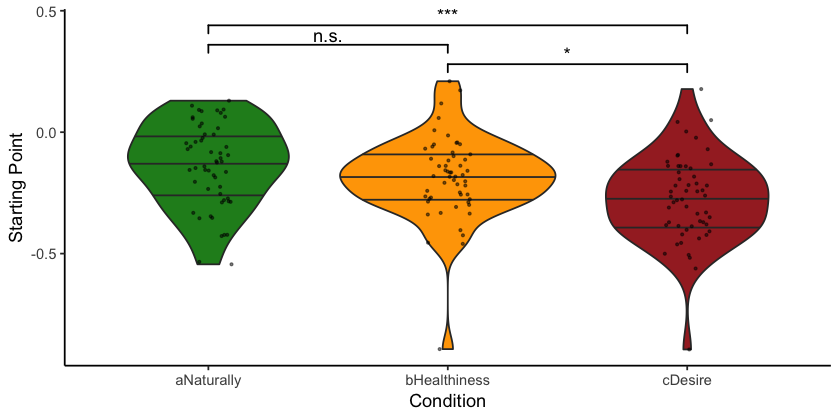

In [32]:
ddm_sp_group = ddm_sp_sub %>%
    se(measurevar = "bound", groupvars = c("cond"))

#pander(ddm_taste_group)
ddm_sp_group


# Plot 
plot = ggplot(ddm_sp_sub, aes(cond, bound, fill = cond)) +
    geom_violin(draw_quantiles = c(0.25, 0.5, 0.75), size=0.5, alpha=1, show.legend = F) + #draw_quantiles = c(0.5)
    #geom_errorbar(aes(ymin = choice-se, ymax = choice+se), width=0.2, data=accept_rate_group) +
    #geom_boxplot(width = .3) +
    geom_jitter(height = 0, width = 0.1, size = 0.5, alpha=0.5, show.legend = F) +
    xlab("Condition") +
    ylab("Starting Point") +
    scale_fill_manual(values = c("forestgreen", "orange", "brown")) +
    theme_classic()

plot + 
    geom_signif(annotations = c("*", "n.s.", "***"),
              y_position = c(.28, .36, .44), xmin=c(2,1,1), xmax=c(3,2,3))

ggsave("../../3_4_outputs/plots/ddm_sp.pdf", width = 20, height = 15, units = "cm")

#### Statistical Significance

In [33]:
sp.aov = aov(bound ~ cond, data = ddm_sp_sub)
summaryh(sp.aov)

term,results
cond,"F(2, 162) = 8.64, p < .001, r = 0.31"


In [34]:
sp.emm = emmeans(sp.aov, list(pairwise ~ cond), adjust = "tukey")
summary(sp.emm$`pairwise differences of cond`)

contrast,estimate,SE,df,t.ratio,p.value
aNaturally - bHealthiness,0.05040545,0.03310533,162,1.522578,0.2830384703
aNaturally - cDesire,0.13609091,0.03310533,162,4.110845,0.0001839658
bHealthiness - cDesire,0.08568545,0.03310533,162,2.588267,0.0282315164


### NDT

In [35]:
head(df_ddm, 3)

Subject,Taste_Nat,Health_Nat,Threshold_Nat,StBias_Nat,NonDec_Nat,Taste_Health,Health_Health,Threshold_Health,StBias_Health,⋯,TasteChange_Nat,HealthChange_Nat,LikingChange_Health,InterceptChange_Health,TasteChange_Health,HealthChange_Health,LikingChange_Desire,InterceptChange_Desire,TasteChange_Desire,HealthChange_Desire
101,0.0631,0.0280,0.0682,-0.2868,0.5615,0.0222,0.0785,0.0628,-0.2571,⋯,0.0468,0.1232,-0.2386,-0.6082,0.0400,0.0536,-0.2159,-0.2875,0.0370,-0.0186
102,0.0585,-0.0045,0.0898,-0.1555,0.3260,0.0305,0.0386,0.1147,-0.2415,⋯,-0.1534,-0.0752,-0.4667,-0.5110,0.0443,-0.0143,-0.3523,0.0792,-0.1399,-0.0436
103,0.0374,0.0266,0.0820,-0.1555,0.3884,0.0334,0.0221,0.0832,-0.1655,⋯,0.0916,-0.2301,-0.0455,0.9144,0.0946,-0.3845,-0.0889,0.1790,0.2342,-0.3125


In [36]:
ddm_ndt_sub = df_ddm %>%
    select(Subject, NonDec_Nat, NonDec_Health, NonDec_Desire) %>%
    gather("NonDec_Nat", "NonDec_Health", "NonDec_Desire",
          key = "cond", value = "ndt")

head(ddm_ndt_sub, 3)

Subject,cond,ndt
101,NonDec_Nat,0.5615
102,NonDec_Nat,0.3260
103,NonDec_Nat,0.3884


#### Means + Plot

##### Violin

cond,N,ndt,sd,se,ci
NonDec_Desire,55,0.5996345,0.1769717,0.02386285,0.04784214
NonDec_Health,55,0.5964927,0.1605113,0.02164334,0.04339229
NonDec_Nat,55,0.5791945,0.1457414,0.01965177,0.03939942


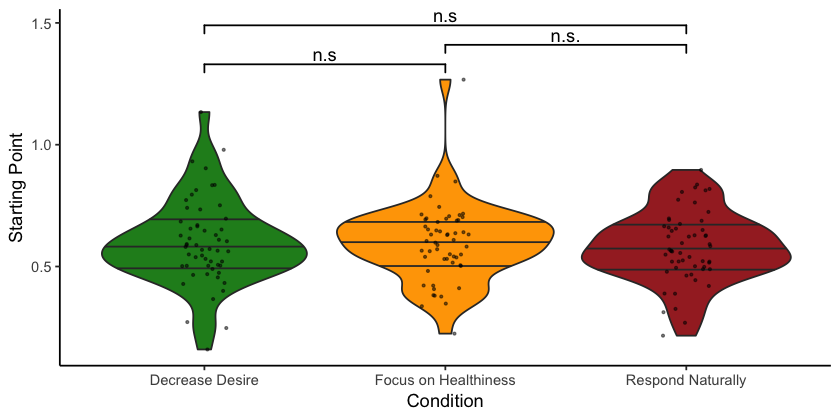

In [38]:
ddm_ndt_group = ddm_ndt_sub %>%
    se(measurevar = "ndt", groupvars = c("cond"))

#pander(ddm_taste_group)
ddm_ndt_group


# Plot 
plot = ggplot(ddm_ndt_sub, aes(cond, ndt, fill = cond)) +
    geom_violin(draw_quantiles = c(0.25, 0.5, 0.75), size=0.5, alpha=1, show.legend = F) + #draw_quantiles = c(0.5)
    #geom_errorbar(aes(ymin = choice-se, ymax = choice+se), width=0.2, data=accept_rate_group) +
    #geom_boxplot(width = .3) +
    geom_jitter(height = 0, width = 0.1, size = 0.5, alpha=0.5, show.legend = F) +
    xlab("Condition") +
    ylab("Starting Point") +
    scale_fill_manual(values = c("forestgreen", "orange", "brown")) +
    scale_x_discrete(labels = c('Decrease Desire','Focus on Healthiness','Respond Naturally')) +
    theme_classic()

plot + 
    geom_signif(annotations = c("n.s", "n.s.", "n.s"),
              y_position = c(1.33, 1.41, 1.49), xmin=c(1,2,1), xmax=c(2,3,3))

ggsave("../../3_4_outputs/plots/ddm_ndt.pdf", width = 20, height = 15, units = "cm")

#### Statistical Significance

In [303]:
ndt.aov = aov(ndt ~ cond, data = ddm_ndt_sub)
summaryh(ndt.aov)

term,results
cond,"F(2, 162) = 0.26, p = .775, r = 0.06"


In [304]:
ndt.emm = emmeans(ndt.aov, list(pairwise ~ cond), adjust = "tukey")
summary(ndt.emm$`pairwise differences of cond`)

contrast,estimate,SE,df,t.ratio,p.value
NonDec_Desire - NonDec_Health,0.003141818,0.03081192,162,0.1019676,0.9942843
NonDec_Desire - NonDec_Nat,0.020440000,0.03081192,162,0.6633795,0.7850278
NonDec_Health - NonDec_Nat,0.017298182,0.03081192,162,0.5614119,0.8407446


## with Constant

In [80]:
# load data
df_ddm_constant = read_csv("../ddm/DDMAnalysis_ConstantModel/DDM_ParameterEstimates_Bayes.csv")

Parsed with column specification:
cols(
  .default = col_double()
)
See spec(...) for full column specifications.


In [81]:
dim(df_ddm_constant)[1]

[1] 55

In [82]:
# Remove rejected subjects 

good_subjects = c(101:104, 106:112, 114, 116, 118:121, 123:126, 129:137, 139:140, 142:148, 150, 152:158, 162:164)
# remove "bad" subjects
df_ddm_constant = df_ddm_constant %>%
    filter(Subject %in% good_subjects)

In [76]:
head(df_ddm_constant, 3)

Subject,Taste_Nat,Health_Nat,Threshold_Nat,StBias_Nat,NonDec_Nat,Taste_Health,Health_Health,Threshold_Health,StBias_Health,⋯,TasteChange_Nat,HealthChange_Nat,LikingChange_Health,InterceptChange_Health,TasteChange_Health,HealthChange_Health,LikingChange_Desire,InterceptChange_Desire,TasteChange_Desire,HealthChange_Desire
101,0.0631,0.0280,0.0682,-0.2868,0.5615,0.0222,0.0785,0.0628,-0.2571,⋯,0.0468,0.1232,-0.2386,-0.6082,0.0400,0.0536,-0.2159,-0.2875,0.0370,-0.0186
102,0.0585,-0.0045,0.0898,-0.1555,0.3260,0.0305,0.0386,0.1147,-0.2415,⋯,-0.1534,-0.0752,-0.4667,-0.5110,0.0443,-0.0143,-0.3523,0.0792,-0.1399,-0.0436
103,0.0374,0.0266,0.0820,-0.1555,0.3884,0.0334,0.0221,0.0832,-0.1655,⋯,0.0916,-0.2301,-0.0455,0.9144,0.0946,-0.3845,-0.0889,0.1790,0.2342,-0.3125


### Taste Weight

In [83]:
ddm_taste_sub = df_ddm_constant %>%
    select(Subject, Taste_Nat, Taste_Health, Taste_Desire) %>%
    gather("Taste_Nat", "Taste_Health", "Taste_Desire",
          key = "cond", value = "weight")

head(ddm_taste_sub, 3)


Subject,cond,weight
101,Taste_Nat,0.0631
102,Taste_Nat,0.0585
103,Taste_Nat,0.0374


In [84]:
ddm_taste_sub$cond = plyr::mapvalues(ddm_taste_sub$cond, 
          from = c("Taste_Nat", "Taste_Health", "Taste_Desire"),
          to = c("aNaturally", "bHealthiness", "cDesire"))


#### Means + Plot

##### Violin

cond,N,weight,sd,se,ci
aNaturally,45,0.03953556,0.02430219,0.003622757,0.007301186
bHealthiness,45,0.01847111,0.02008354,0.002993877,0.006033763
cDesire,45,0.01550667,0.02218870,0.003307696,0.006666223


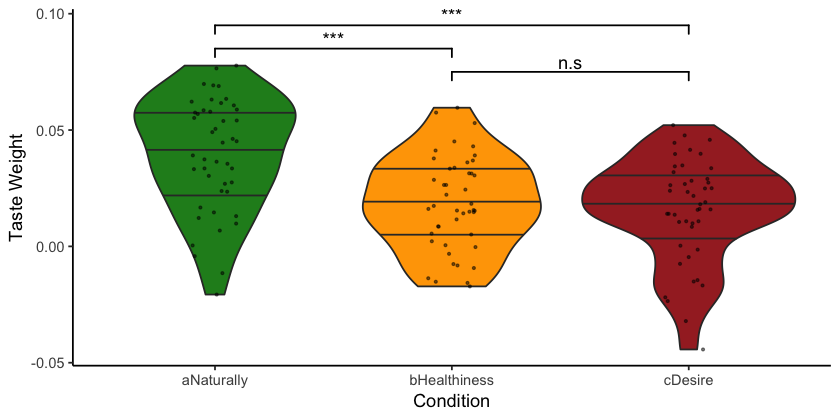

In [90]:
ddm_taste_group = ddm_taste_sub %>%
    se(measurevar = "weight", groupvars = c("cond"))

#pander(ddm_taste_group)
ddm_taste_group


# Plot 
plot = ggplot(ddm_taste_sub, aes(cond, weight, fill = cond)) +
    geom_violin(draw_quantiles = c(0.25, 0.75), size=0.5, alpha=0.8, show.legend = F) +
    geom_linerange(aes(ymin = weight-se, ymax = weight+se), size=25, alpha=0.4, data=ddm_taste_group) +
    geom_crossbar(stat="summary", fun.y=mean, fun.ymax=mean, fun.ymin=mean, fatten=2, width=0.6, show.legend = F) +
    geom_jitter(height = 0, width = 0.1, size = 0.5, alpha=0.5, show.legend = F) +
    xlab("Condition") +
    ylab("Taste Weight") +
    scale_fill_manual(values = c("forestgreen", "orange", "brown")) +
    theme_classic()

plot + 
    geom_signif(annotations = c("n.s", "***", "***"),
              y_position = c(.075, .085, .095), xmin=c(2,1,1), xmax=c(3,2,3))

ggsave("../../3_4_outputs/plots/ddm_taste.pdf", width = 20, height = 15, units = "cm")


#### Statistical Significance

In [86]:
taste.aov = aov(weight ~ cond, data = ddm_taste_sub)
summaryh(taste.aov)

term,results
cond,"F(2, 132) = 15.59, p < .001, r = 0.44"


In [87]:
taste.emm = emmeans(taste.aov, list(pairwise ~ cond), adjust = "tukey")
summary(taste.emm$`pairwise differences of cond`)

contrast,estimate,SE,df,t.ratio,p.value
aNaturally - bHealthiness,0.021064444,0.004692442,132,4.4890155,4.569415e-05
aNaturally - cDesire,0.024028889,0.004692442,132,5.1207642,3.139514e-06
bHealthiness - cDesire,0.002964444,0.004692442,132,0.6317488,8.029308e-01


### Health Weight

In [91]:
ddm_health_sub = df_ddm_constant %>%
    select(Subject, Health_Nat, Health_Health, Health_Desire) %>%
    gather("Health_Nat", "Health_Health", "Health_Desire",
          key = "cond", value = "weight")

ddm_health_sub$cond = plyr::mapvalues(ddm_health_sub$cond, 
          from = c("Health_Nat", "Health_Health", "Health_Desire"),
          to = c("aNaturally", "bHealthiness", "cDesire"))

head(ddm_health_sub, 3)


Subject,cond,weight
101,aNaturally,0.0280
102,aNaturally,-0.0045
103,aNaturally,0.0266


#### Means + Plot

##### Violin

cond,N,weight,sd,se,ci
aNaturally,45,0.008453333,0.01670866,0.00249078,0.005019838
bHealthiness,45,0.038615556,0.02605728,0.00388439,0.007828473
cDesire,45,0.010088889,0.01785154,0.00266115,0.005363195


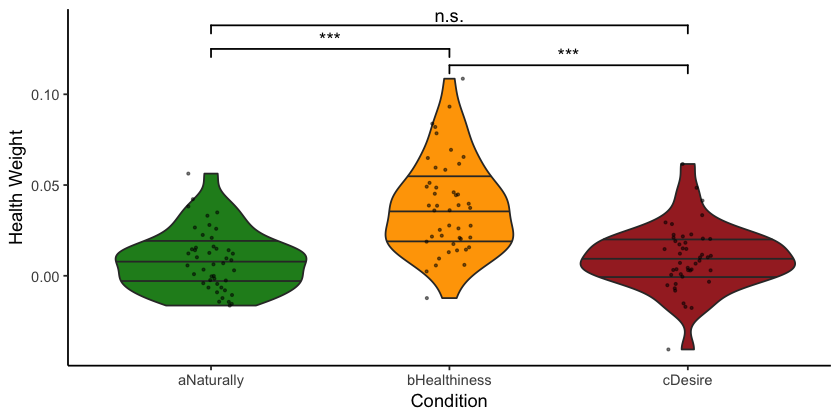

In [92]:
ddm_health_group = ddm_health_sub %>%
    se(measurevar = "weight", groupvars = c("cond"))

#pander(ddm_taste_group)
ddm_health_group


# Plot 
plot = ggplot(ddm_health_sub, aes(cond, weight, fill = cond)) +
    geom_violin(draw_quantiles = c(0.25, 0.75), size=0.5, alpha=0.8, show.legend = F) +
    geom_linerange(aes(ymin = weight-se, ymax = weight+se), size=25, alpha=0.4, data=ddm_health_group) +
    geom_crossbar(stat="summary", fun.y=mean, fun.ymax=mean, fun.ymin=mean, fatten=2, width=0.6, show.legend = F) +
    geom_jitter(height = 0, width = 0.1, size = 0.5, alpha=0.5, show.legend = F) +
    xlab("Condition") +
    ylab("Health Weight") +
    scale_fill_manual(values = c("forestgreen", "orange", "brown")) +
    theme_classic()

plot + 
    geom_signif(annotations = c("***", "***", "n.s."),
              y_position = c(.116, .125, .138), xmin=c(2,1,1), xmax=c(3,2,3))

ggsave("../../3_4_outputs/plots/ddm_health.pdf", width = 20, height = 15, units = "cm")


#### Statistical Significance

In [93]:
health.aov = aov(weight ~ cond, data = ddm_health_sub)
summaryh(health.aov)

term,results
cond,"F(2, 132) = 30.42, p < .001, r = 0.56"


In [94]:
health.emm = emmeans(health.aov, list(pairwise ~ cond), adjust = "tukey")
summary(health.emm$`pairwise differences of cond`)

contrast,estimate,SE,df,t.ratio,p.value
aNaturally - bHealthiness,-0.030162222,0.004349267,132,-6.9350122,4.906379e-10
aNaturally - cDesire,-0.001635556,0.004349267,132,-0.3760531,9.250596e-01
bHealthiness - cDesire,0.028526667,0.004349267,132,6.5589591,3.364276e-09


### Boundary

In [27]:
head(df_ddm, 3)


Subject,Taste_Nat,Health_Nat,Threshold_Nat,StBias_Nat,NonDec_Nat,Taste_Health,Health_Health,Threshold_Health,StBias_Health,⋯,TasteChange_Nat,HealthChange_Nat,LikingChange_Health,InterceptChange_Health,TasteChange_Health,HealthChange_Health,LikingChange_Desire,InterceptChange_Desire,TasteChange_Desire,HealthChange_Desire
101,0.0631,0.0280,0.0682,-0.2868,0.5615,0.0222,0.0785,0.0628,-0.2571,⋯,0.0468,0.1232,-0.2386,-0.6082,0.0400,0.0536,-0.2159,-0.2875,0.0370,-0.0186
102,0.0585,-0.0045,0.0898,-0.1555,0.3260,0.0305,0.0386,0.1147,-0.2415,⋯,-0.1534,-0.0752,-0.4667,-0.5110,0.0443,-0.0143,-0.3523,0.0792,-0.1399,-0.0436
103,0.0374,0.0266,0.0820,-0.1555,0.3884,0.0334,0.0221,0.0832,-0.1655,⋯,0.0916,-0.2301,-0.0455,0.9144,0.0946,-0.3845,-0.0889,0.1790,0.2342,-0.3125


In [95]:
ddm_bound_sub = df_ddm_constant %>%
    select(Subject, Threshold_Nat, Threshold_Health, Threshold_Desire) %>%
    gather("Threshold_Nat", "Threshold_Health", "Threshold_Desire",
          key = "cond", value = "bound")

# remove outlier
ddm_bound_sub = ddm_bound_sub %>%
    filter(bound<0.3)

head(ddm_bound_sub, 3)


Subject,cond,bound
101,Threshold_Nat,0.0682
102,Threshold_Nat,0.0898
103,Threshold_Nat,0.0820


#### Means + Plot

##### Violin

cond,N,bound,sd,se,ci
Threshold_Desire,45,0.1107200,0.02700736,0.004026020,0.008113909
Threshold_Health,45,0.1068978,0.02534881,0.003778777,0.007615625
Threshold_Nat,45,0.0990000,0.02151809,0.003207727,0.006464750


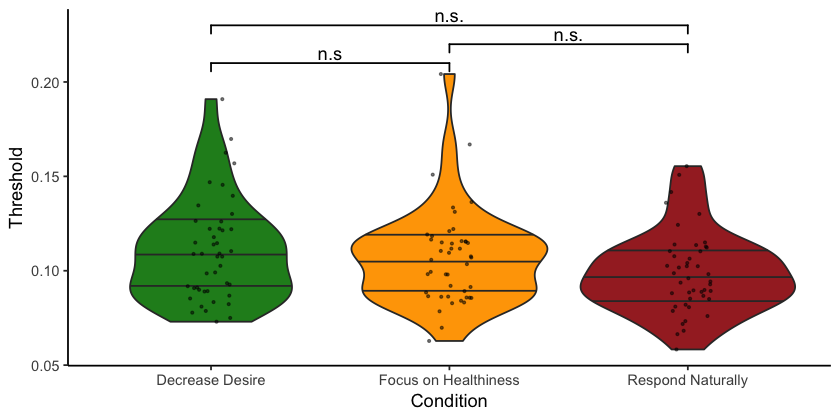

In [96]:
ddm_bound_group = ddm_bound_sub %>%
    se(measurevar = "bound", groupvars = c("cond"))

#pander(ddm_taste_group)
ddm_bound_group


# Plot 
plot = ggplot(ddm_bound_sub, aes(cond, bound, fill = cond)) +
    geom_violin(draw_quantiles = c(0.25, 0.75), size=0.5, alpha=0.8, show.legend = F) +
    geom_linerange(aes(ymin = weight-se, ymax = weight+se), size=25, alpha=0.4, data=ddm_bound_group) +
    geom_crossbar(stat="summary", fun.y=mean, fun.ymax=mean, fun.ymin=mean, fatten=2, width=0.6, show.legend = F) +
    geom_jitter(height = 0, width = 0.1, size = 0.5, alpha=0.5, show.legend = F) +
    xlab("Condition") +
    ylab("Threshold") +
    scale_fill_manual(values = c("forestgreen", "orange", "brown")) +
    theme_classic()

plot + 
    geom_signif(annotations = c("n.s", "n.s.", "n.s."),
              y_position = c(.21, .22, .23), xmin=c(1,2,1), xmax=c(2,3,3))

ggsave("../../3_4_outputs/plots/ddm_bound.pdf", width = 20, height = 15, units = "cm")


#### Statistical Significance

In [97]:
bound.aov = aov(bound ~ cond, data = ddm_bound_sub)
summaryh(bound.aov)

term,results
cond,"F(2, 132) = 2.63, p = .076, r = 0.20"


In [98]:
bound.emm = emmeans(bound.aov, list(pairwise ~ cond), adjust = "tukey")
summary(bound.emm$`pairwise differences of cond`)

contrast,estimate,SE,df,t.ratio,p.value
Threshold_Desire - Threshold_Health,0.003822222,0.005213924,132,0.7330798,0.7443171
Threshold_Desire - Threshold_Nat,0.011720000,0.005213924,132,2.2478271,0.0670387
Threshold_Health - Threshold_Nat,0.007897778,0.005213924,132,1.5147474,0.2873050


### SP Bias

In [101]:
head(df_ddm_constant, 3)

Subject,Taste_Nat,Health_Nat,Threshold_Nat,StBias_Nat,NonDec_Nat,Taste_Health,Health_Health,Threshold_Health,StBias_Health,⋯,TasteChange_Nat,HealthChange_Nat,LikingChange_Health,InterceptChange_Health,TasteChange_Health,HealthChange_Health,LikingChange_Desire,InterceptChange_Desire,TasteChange_Desire,HealthChange_Desire
101,0.0631,0.0280,0.0682,-0.2868,0.5615,0.0222,0.0785,0.0628,-0.2571,⋯,0.0468,0.1232,-0.2386,-0.6082,0.0400,0.0536,-0.2159,-0.2875,0.0370,-0.0186
102,0.0585,-0.0045,0.0898,-0.1555,0.3260,0.0305,0.0386,0.1147,-0.2415,⋯,-0.1534,-0.0752,-0.4667,-0.5110,0.0443,-0.0143,-0.3523,0.0792,-0.1399,-0.0436
103,0.0374,0.0266,0.0820,-0.1555,0.3884,0.0334,0.0221,0.0832,-0.1655,⋯,0.0916,-0.2301,-0.0455,0.9144,0.0946,-0.3845,-0.0889,0.1790,0.2342,-0.3125


In [102]:
ddm_sp_sub = df_ddm_constant %>%
    select(Subject, StBias_Nat, StBias_Health, StBias_Desire) %>%
    gather("StBias_Nat", "StBias_Health", "StBias_Desire",
          key = "cond", value = "bound")

ddm_sp_sub$cond = plyr::mapvalues(ddm_sp_sub$cond, 
          from = c("StBias_Nat", "StBias_Health", "StBias_Desire"),
          to = c("aNaturally", "bHealthiness", "cDesire"))

head(ddm_sp_sub, 3)

Subject,cond,bound
101,aNaturally,-0.2868
102,aNaturally,-0.1555
103,aNaturally,-0.1555


#### Means + Plot

##### Violin

cond,N,bound,sd,se,ci
aNaturally,45,-0.1461022,0.1609973,0.02400006,0.04836894
bHealthiness,45,-0.1715578,0.1456364,0.02171019,0.04375401
cDesire,45,-0.2646756,0.1598797,0.02383347,0.04803319


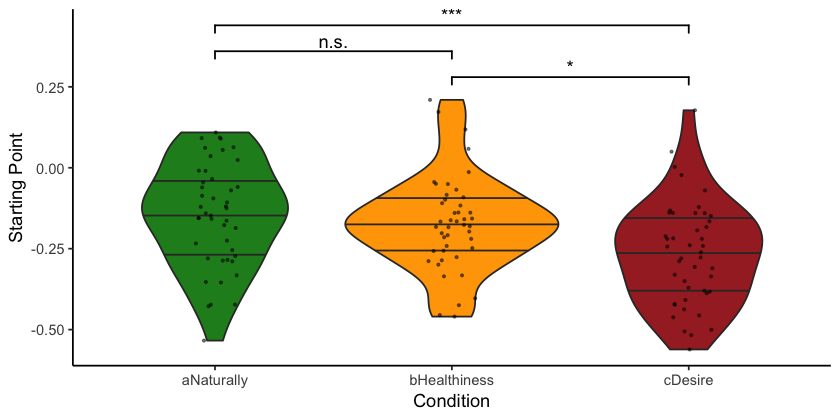

In [103]:
ddm_sp_group = ddm_sp_sub %>%
    se(measurevar = "bound", groupvars = c("cond"))

#pander(ddm_taste_group)
ddm_sp_group


# Plot 
plot = ggplot(ddm_sp_sub, aes(cond, bound, fill = cond)) +
    geom_violin(draw_quantiles = c(0.25, 0.5, 0.75), size=0.5, alpha=1, show.legend = F) + #draw_quantiles = c(0.5)
    #geom_errorbar(aes(ymin = choice-se, ymax = choice+se), width=0.2, data=accept_rate_group) +
    #geom_boxplot(width = .3) +
    geom_jitter(height = 0, width = 0.1, size = 0.5, alpha=0.5, show.legend = F) +
    xlab("Condition") +
    ylab("Starting Point") +
    scale_fill_manual(values = c("forestgreen", "orange", "brown")) +
    theme_classic()

plot + 
    geom_signif(annotations = c("*", "n.s.", "***"),
              y_position = c(.28, .36, .44), xmin=c(2,1,1), xmax=c(3,2,3))

ggsave("../../3_4_outputs/plots/ddm_sp.pdf", width = 20, height = 15, units = "cm")

#### Statistical Significance

In [104]:
sp.aov = aov(bound ~ cond, data = ddm_sp_sub)
summaryh(sp.aov)

term,results
cond,"F(2, 132) = 7.24, p = .001, r = 0.31"


In [105]:
sp.emm = emmeans(sp.aov, list(pairwise ~ cond), adjust = "tukey")
summary(sp.emm$`pairwise differences of cond`)

contrast,estimate,SE,df,t.ratio,p.value
aNaturally - bHealthiness,0.02545556,0.03281635,132,0.7756973,0.718574096
aNaturally - cDesire,0.11857333,0.03281635,132,3.6132395,0.001239592
bHealthiness - cDesire,0.09311778,0.03281635,132,2.8375421,0.014472304


### NDT

In [35]:
head(df_ddm, 3)

Subject,Taste_Nat,Health_Nat,Threshold_Nat,StBias_Nat,NonDec_Nat,Taste_Health,Health_Health,Threshold_Health,StBias_Health,⋯,TasteChange_Nat,HealthChange_Nat,LikingChange_Health,InterceptChange_Health,TasteChange_Health,HealthChange_Health,LikingChange_Desire,InterceptChange_Desire,TasteChange_Desire,HealthChange_Desire
101,0.0631,0.0280,0.0682,-0.2868,0.5615,0.0222,0.0785,0.0628,-0.2571,⋯,0.0468,0.1232,-0.2386,-0.6082,0.0400,0.0536,-0.2159,-0.2875,0.0370,-0.0186
102,0.0585,-0.0045,0.0898,-0.1555,0.3260,0.0305,0.0386,0.1147,-0.2415,⋯,-0.1534,-0.0752,-0.4667,-0.5110,0.0443,-0.0143,-0.3523,0.0792,-0.1399,-0.0436
103,0.0374,0.0266,0.0820,-0.1555,0.3884,0.0334,0.0221,0.0832,-0.1655,⋯,0.0916,-0.2301,-0.0455,0.9144,0.0946,-0.3845,-0.0889,0.1790,0.2342,-0.3125


In [36]:
ddm_ndt_sub = df_ddm %>%
    select(Subject, NonDec_Nat, NonDec_Health, NonDec_Desire) %>%
    gather("NonDec_Nat", "NonDec_Health", "NonDec_Desire",
          key = "cond", value = "ndt")

head(ddm_ndt_sub, 3)

Subject,cond,ndt
101,NonDec_Nat,0.5615
102,NonDec_Nat,0.3260
103,NonDec_Nat,0.3884


#### Means + Plot

##### Violin

cond,N,ndt,sd,se,ci
NonDec_Desire,55,0.5996345,0.1769717,0.02386285,0.04784214
NonDec_Health,55,0.5964927,0.1605113,0.02164334,0.04339229
NonDec_Nat,55,0.5791945,0.1457414,0.01965177,0.03939942


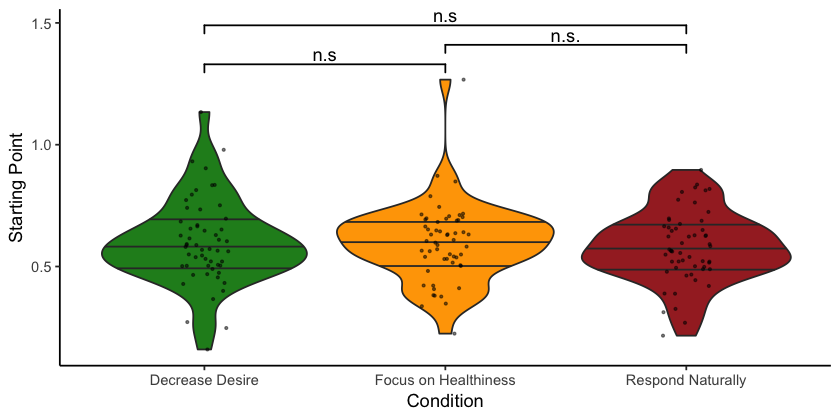

In [38]:
ddm_ndt_group = ddm_ndt_sub %>%
    se(measurevar = "ndt", groupvars = c("cond"))

#pander(ddm_taste_group)
ddm_ndt_group


# Plot 
plot = ggplot(ddm_ndt_sub, aes(cond, ndt, fill = cond)) +
    geom_violin(draw_quantiles = c(0.25, 0.5, 0.75), size=0.5, alpha=1, show.legend = F) + #draw_quantiles = c(0.5)
    #geom_errorbar(aes(ymin = choice-se, ymax = choice+se), width=0.2, data=accept_rate_group) +
    #geom_boxplot(width = .3) +
    geom_jitter(height = 0, width = 0.1, size = 0.5, alpha=0.5, show.legend = F) +
    xlab("Condition") +
    ylab("Starting Point") +
    scale_fill_manual(values = c("forestgreen", "orange", "brown")) +
    scale_x_discrete(labels = c('Decrease Desire','Focus on Healthiness','Respond Naturally')) +
    theme_classic()

plot + 
    geom_signif(annotations = c("n.s", "n.s.", "n.s"),
              y_position = c(1.33, 1.41, 1.49), xmin=c(1,2,1), xmax=c(2,3,3))

ggsave("../../3_4_outputs/plots/ddm_ndt.pdf", width = 20, height = 15, units = "cm")

#### Statistical Significance

In [303]:
ndt.aov = aov(ndt ~ cond, data = ddm_ndt_sub)
summaryh(ndt.aov)

term,results
cond,"F(2, 162) = 0.26, p = .775, r = 0.06"


In [304]:
ndt.emm = emmeans(ndt.aov, list(pairwise ~ cond), adjust = "tukey")
summary(ndt.emm$`pairwise differences of cond`)

contrast,estimate,SE,df,t.ratio,p.value
NonDec_Desire - NonDec_Health,0.003141818,0.03081192,162,0.1019676,0.9942843
NonDec_Desire - NonDec_Nat,0.020440000,0.03081192,162,0.6633795,0.7850278
NonDec_Health - NonDec_Nat,0.017298182,0.03081192,162,0.5614119,0.8407446


# Success by Condition

### Summary DF

In [147]:
# use the change in slopes
success_temp = dt_merged %>%
    group_by(cond, subject) %>%
    summarise(health_change = mean(health_slope_change),
             taste_change = mean(taste_slope_change),
             hw = mean(health_slope),
             tw = mean(taste_slope))

Get taste and health weight change by condition (natural not needed)

In [154]:
head(success_temp,2)

cond,subject,health_change,taste_change,hw,tw
Respond Naturally,101,0,0,0.10423377,0.4155784
Respond Naturally,102,0,0,0.09125025,0.2811279


### Weighting

In [155]:
weight_health = success_temp %>% 
    select(cond, subject, hw) %>% 
    spread(cond, hw)

names(weight_health)=c("Subject", "Natural.hw", "Health.hw", "Decrease.hw")

head(weight_health,2)

Subject,Natural.hw,Health.hw,Decrease.hw
101,0.10423377,0.1948491,0.07434354
102,0.09125025,0.2847252,0.12059167


In [153]:
weight_taste = success_temp %>% 
    select(cond, subject, tw) %>% 
    spread(cond, tw)

names(weight_taste)=c("Subject", "Natural.tw", "Health.tw", "Decrease.tw")

head(weight_taste,2)

Subject,Natural.tw,Health.tw,Decrease.tw
101,0.4155784,0.2763912,0.3174135
102,0.2811279,0.1482429,0.2543863


### Success

In [160]:
success_taste = success_temp %>% 
    select(cond, subject, taste_change) %>% 
    spread(cond, taste_change) %>% 
    select(-`Respond Naturally`) 

names(success_taste) <- c("Subject", "Health.tw_change", "Decrease.tw_change")
head(success_taste,2)

Subject,Health.tw_change,Decrease.tw_change
101,-0.1391872,-0.09816493
102,-0.1328850,-0.02674156


In [161]:
success_health = success_temp %>% 
    select(cond, subject, health_change) %>% 
    spread(cond, health_change) %>% 
    select(-`Respond Naturally`) 

names(success_health) <- c("Subject", "Health.hw_change", "Decrease.hw_change")
head(success_health,2)

Subject,Health.hw_change,Decrease.hw_change
101,0.09061531,-0.02989023
102,0.19347491,0.02934141


In [164]:
temp = left_join(success_taste, success_health, by="Subject")

In [166]:
cond_success = temp %>% 
    mutate(Health.success_trial = Health.hw_change - Health.tw_change,
           Decrease.success_trial = -1 * Decrease.tw_change) %>%
    select(Subject, Health.success_trial, Decrease.success_trial)

head(cond_success,2)

Subject,Health.success_trial,Decrease.success_trial
101,0.2298025,0.09816493
102,0.3263599,0.02674156


### Join

In [167]:
temp = left_join(cond_success, weight_health, by="Subject")
reg_success = left_join(temp, weight_taste, by="Subject")
head(reg_success,2)

Subject,Health.success_trial,Decrease.success_trial,Natural.hw,Health.hw,Decrease.hw,Natural.tw,Health.tw,Decrease.tw
101,0.2298025,0.09816493,0.10423377,0.1948491,0.07434354,0.4155784,0.2763912,0.3174135
102,0.3263599,0.02674156,0.09125025,0.2847252,0.12059167,0.2811279,0.1482429,0.2543863


### Save

In [168]:
# save for `fr_results_neural`
saveRDS(reg_success, "../data/reg_success_trial.rds")

# Functions

## Plotting

In [1]:
my_v_plot = function(df, measurevar, xlab, ylab){
    group = df %>%
        se(measurevar = "bound", groupvars = c("cond"))

    print(ddm_bound_group)
    
    plot = ggplot(ddm_bound_sub, aes(cond, bound, fill = cond)) +
        geom_violin(draw_quantiles = c(0.25, 0.75), size=0.5, alpha=0.8, show.legend = F) +
        geom_linerange(aes(ymin = weight-se, ymax = weight+se), size=25, alpha=0.4, data=ddm_bound_group) +
        geom_crossbar(stat="summary", fun.y=mean, fun.ymax=mean, fun.ymin=mean, fatten=2, width=0.6, show.legend = F) +
        geom_jitter(height = 0, width = 0.1, size = 0.5, alpha=0.5, show.legend = F) +
        xlab("Condition") +
        ylab("Threshold") +
        scale_fill_manual(values = c("forestgreen", "orange", "brown")) +
        theme_classic()
        return(plot)
}